In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import colormaps
colormap = colormaps.get_cmap('Dark2')


In [2]:
def plot_fc(ts=0,tidx=0,history=10,benchmarks=True,benchmark_models=['tft'],f=7,save=False):

    if type(ts) == int:
        ts = tss[ts]
    if type(tidx) == int:
        tidx = tidxs[tidx]

    ts_data = data[(data['time_series'] == ts) & (data['time_idx'] == tidx)]
    ts_data = ts_data.set_index('pred_idx')

    actual_data = actuals[(actuals['time_series'] == ts ) & (actuals['time_idx'] <= ts_data.index.max()) & (actuals['time_idx'] >= ts_data.index.min() - history)].set_index('time_idx')



    x_level = ts_data['effect_x_level']
    x_weekday = ts_data['effect_weekday']
    causals = ts_data.columns[(ts_data.columns.str.contains('effect')) & ~(ts_data.columns.str.contains('effect_x_level')) & ~(ts_data.columns.str.contains('effect_weekday'))]
    # causals = list(ts_data[causals].abs().sum().sort_values(ascending=False).index)
    causalnames = [c.split('_')[1].capitalize() for c in causals]

    sel = ts_data[causals].abs().rank(axis=1,method='first',ascending=False).melt(ignore_index=False).pivot_table(index='pred_idx', columns='value', values='variable',aggfunc='first')
    effects = sel.copy()
    for index,values in sel.iterrows():
        effects.loc[index] = ts_data.loc[index,values.values].values

    effects_cum = effects.copy()
    effects_cum = effects_cum.cumsum(axis=1).shift(1,axis=1)

    colors = list(colormap.colors)
    colors.pop(1)

    fig = plt.figure(figsize=(15,5),dpi=200)
    plt.plot( actual_data['sales'],label='Actual',color='red')

    if benchmarks:
        for bm in benchmark_models:
            plt.plot(ts_data[bm],label=bm.upper(),linestyle='--',color=colors.pop(0))



    plt.plot(ts_data['pred'],label='HNAM',color='black',linestyle='--')

    # find rmse and smape of hnam and of benchmarks
    rmse = np.sqrt(np.mean((ts_data['pred'] - actual_data['sales'])**2))
    smape = 1/len(actual_data) * np.sum(2 * np.abs(ts_data['pred'] - actual_data['sales']) / (np.abs(ts_data['pred']) + np.abs(actual_data['sales'])))


    tft_rmse = np.sqrt(np.mean((ts_data['tft'] - actual_data['sales'])**2))
    tft_smape = 1/len(actual_data) * np.sum(2 * np.abs(ts_data['tft'] - actual_data['sales']) / (np.abs(ts_data['tft']) + np.abs(actual_data['sales'])))


        
    # annotate rmse and smape of hnam and of the benchmarks
    # plt.text(actual_data.index[0] + 3, actual_data['sales'].max() * 0.7, f'HNAM RMSE: {rmse:.2f}, SMAPE: {smape:.2f}', fontsize=8)
    # for bm in benchmark_models:
    #     plt.text(actual_data.index[0] + 3, actual_data['sales'].max() * 0.6, f'TFT RMSE: {rmse:.2f}, SMAPE {bm.upper()}: {smape:.2f}', fontsize=8, ha='left', va='bottom')
        
    

    ts_data['effect_x_level'].plot(label='Level',color='lightblue',alpha=0.7)
    plt.bar(x = effects.index + np.where(x_weekday > 0,0.04,-0.04), height = x_weekday.values, bottom = x_level,width=0.15,label='Weekday',color=colors.pop(0))
    # come up with a nice color palette
    for causal,causalname,color in zip(causals,causalnames,colors):
        mask = sel[sel==causal].notnull()
        bottoms = effects_cum[mask].fillna(0).sum(axis=1)
        bottoms = bottoms + x_level + x_weekday
        causal_effects = effects[mask].fillna(0).sum(axis=1)
        plt.bar(x = effects.index + np.where(causal_effects > 0,0.04,-0.04), height = causal_effects.values, bottom = bottoms,width=0.15,alpha=0.7,label=causalname,color=color)


    plt.xticks(actual_data.index[::f])
    plt.legend()
    plt.grid(color='black', linestyle='-', linewidth=0.1)
    plt.xlabel('Time Index')
    plt.ylabel('Sales')

    title_x = 0.18
    title_y = 0.95
    delta_y = 0.05
    plt.text(title_x, title_y, f'Time Series {ts}', ha='left', va='center', fontsize=12, weight='bold', transform=plt.gca().transAxes)
    plt.text(title_x, title_y - delta_y, f'HNAM RMSE: {rmse:.2f},   SMAPE: {smape:.2f}', ha='left', va='center', fontsize=10, transform=plt.gca().transAxes)
    plt.text(title_x, title_y - 2 * delta_y, f'TFT     RMSE: {tft_rmse:.2f},   SMAPE: {tft_smape:.2f}', ha='left', va='center', fontsize=10, transform=plt.gca().transAxes)

    plt.show()
    if save:
        fig.savefig(f'plots/{DATASET.lower()}-{ts}-{tidx}.png',bbox_inches='tight',dpi=300,transparent=True,facecolor='w',edgecolor='w')



In [3]:
DATASET = 'Walmart'
data = pd.read_pickle(f'../Evaluation/{DATASET}/hnam.pkl')
ets_pred = pd.read_pickle(f'../Evaluation/{DATASET}/ets.pkl').rename(columns={'pred': 'ets'})
arima_pred = pd.read_pickle(f'../Evaluation/{DATASET}/sarimax.pkl').rename(columns={'pred': 'arima'})
tft_pred = pd.read_pickle(f'../Evaluation/{DATASET}/tft.pkl').rename(columns={'pred': 'tft'})

data = data.merge(ets_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
data = data.merge(arima_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
data = data.merge(tft_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
actuals = pd.read_pickle(f'../Processed/{DATASET}/{DATASET.lower()}_data.pkl').query('time_idx > @data.time_idx.min() - 200')
actuals['time_idx'] = actuals['time_idx'].astype(int)
data['time_idx'] = data['time_idx'].astype(int)
data['pred_idx'] = data['pred_idx'].astype(int)
tss = list(data['time_series'].unique())
tidxs = list(data['time_idx'].unique())


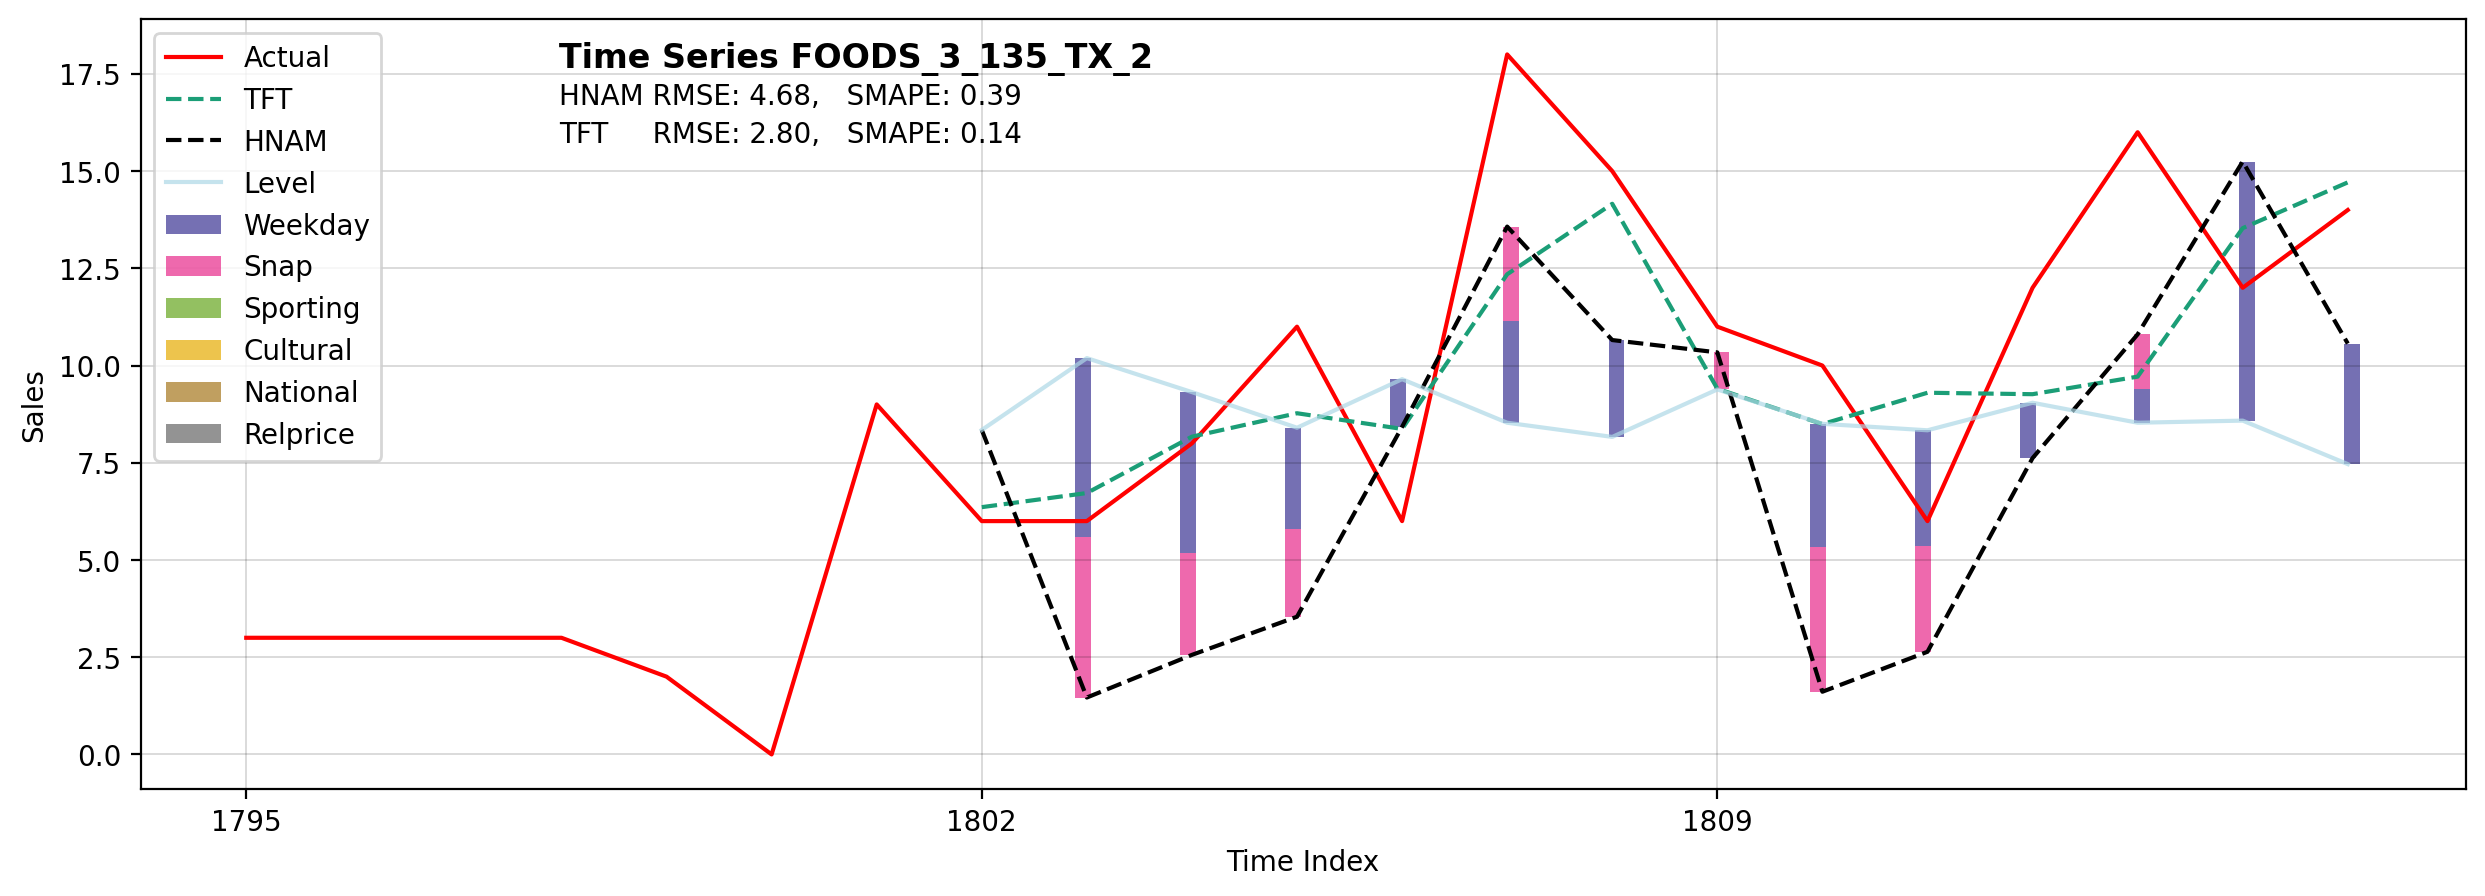

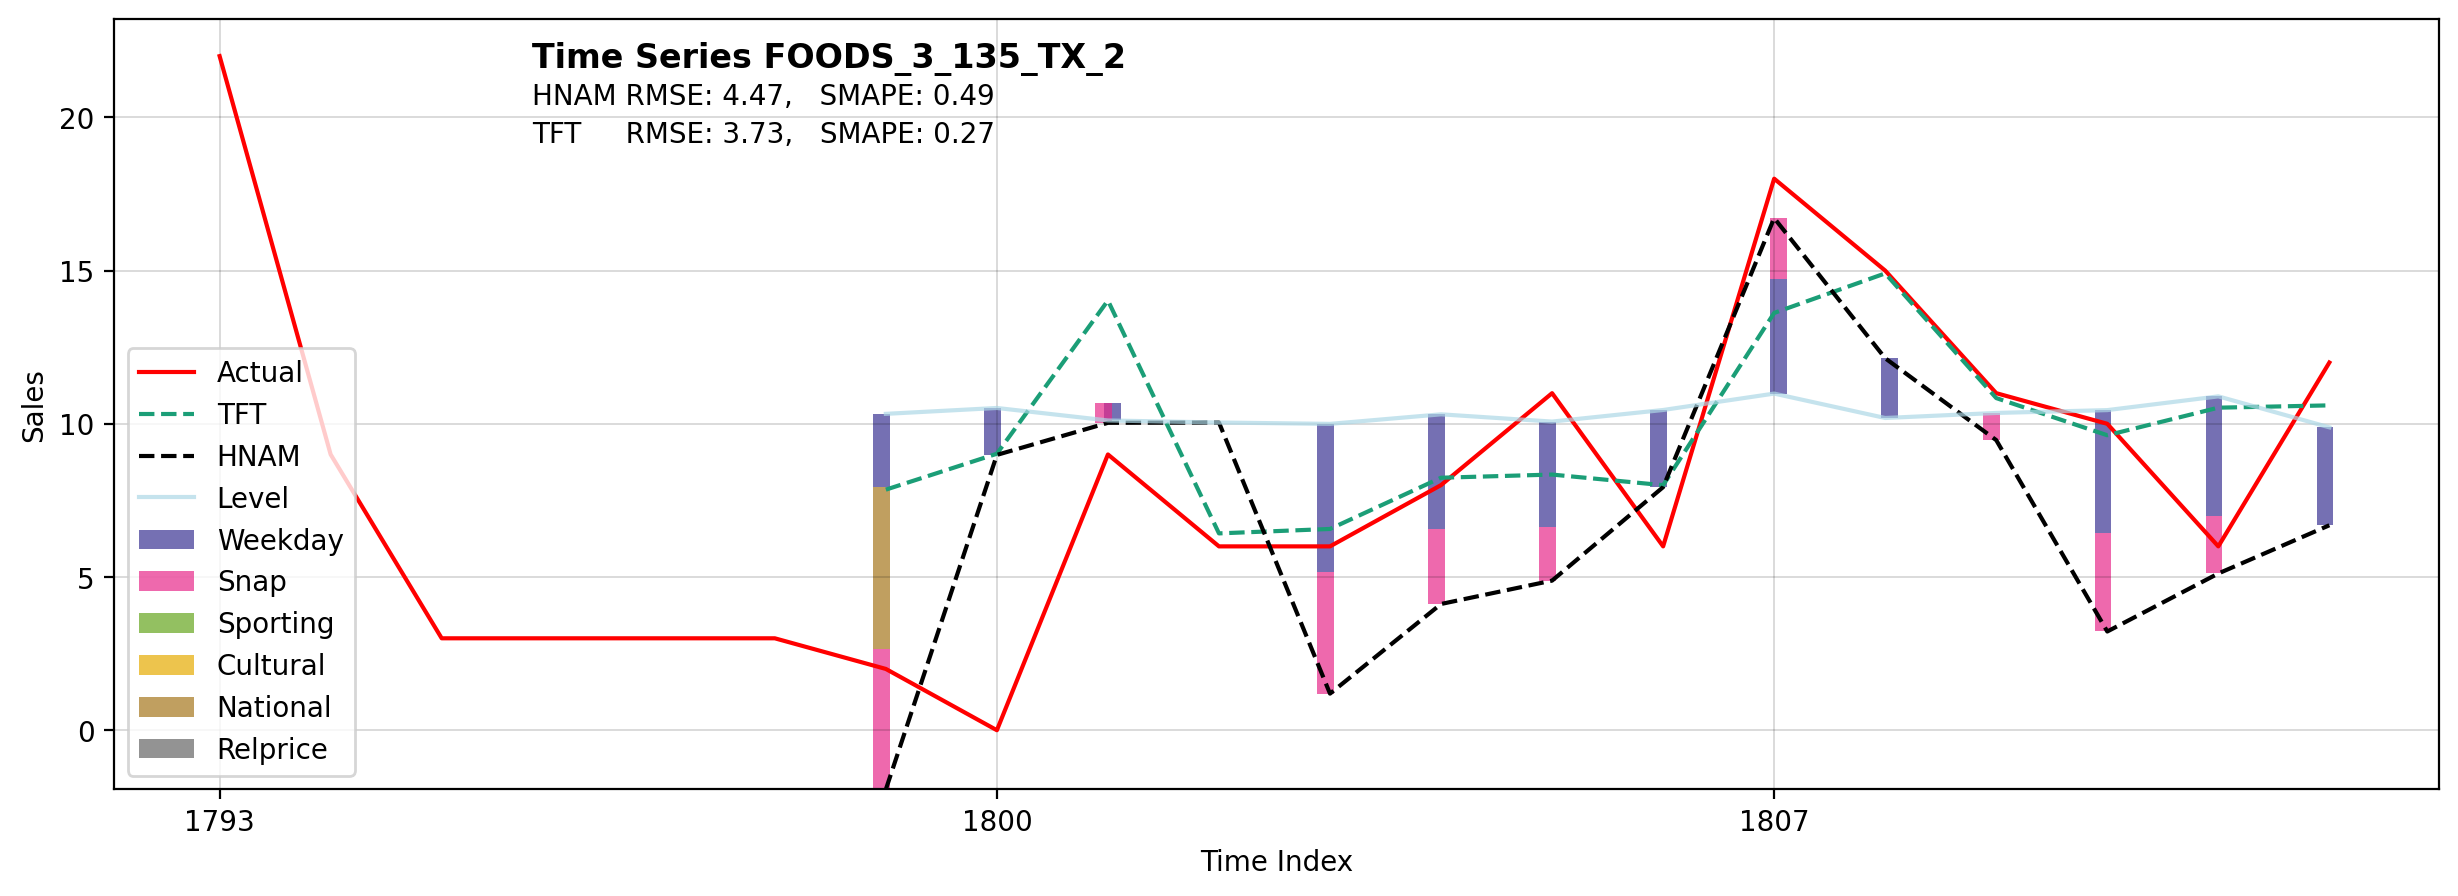

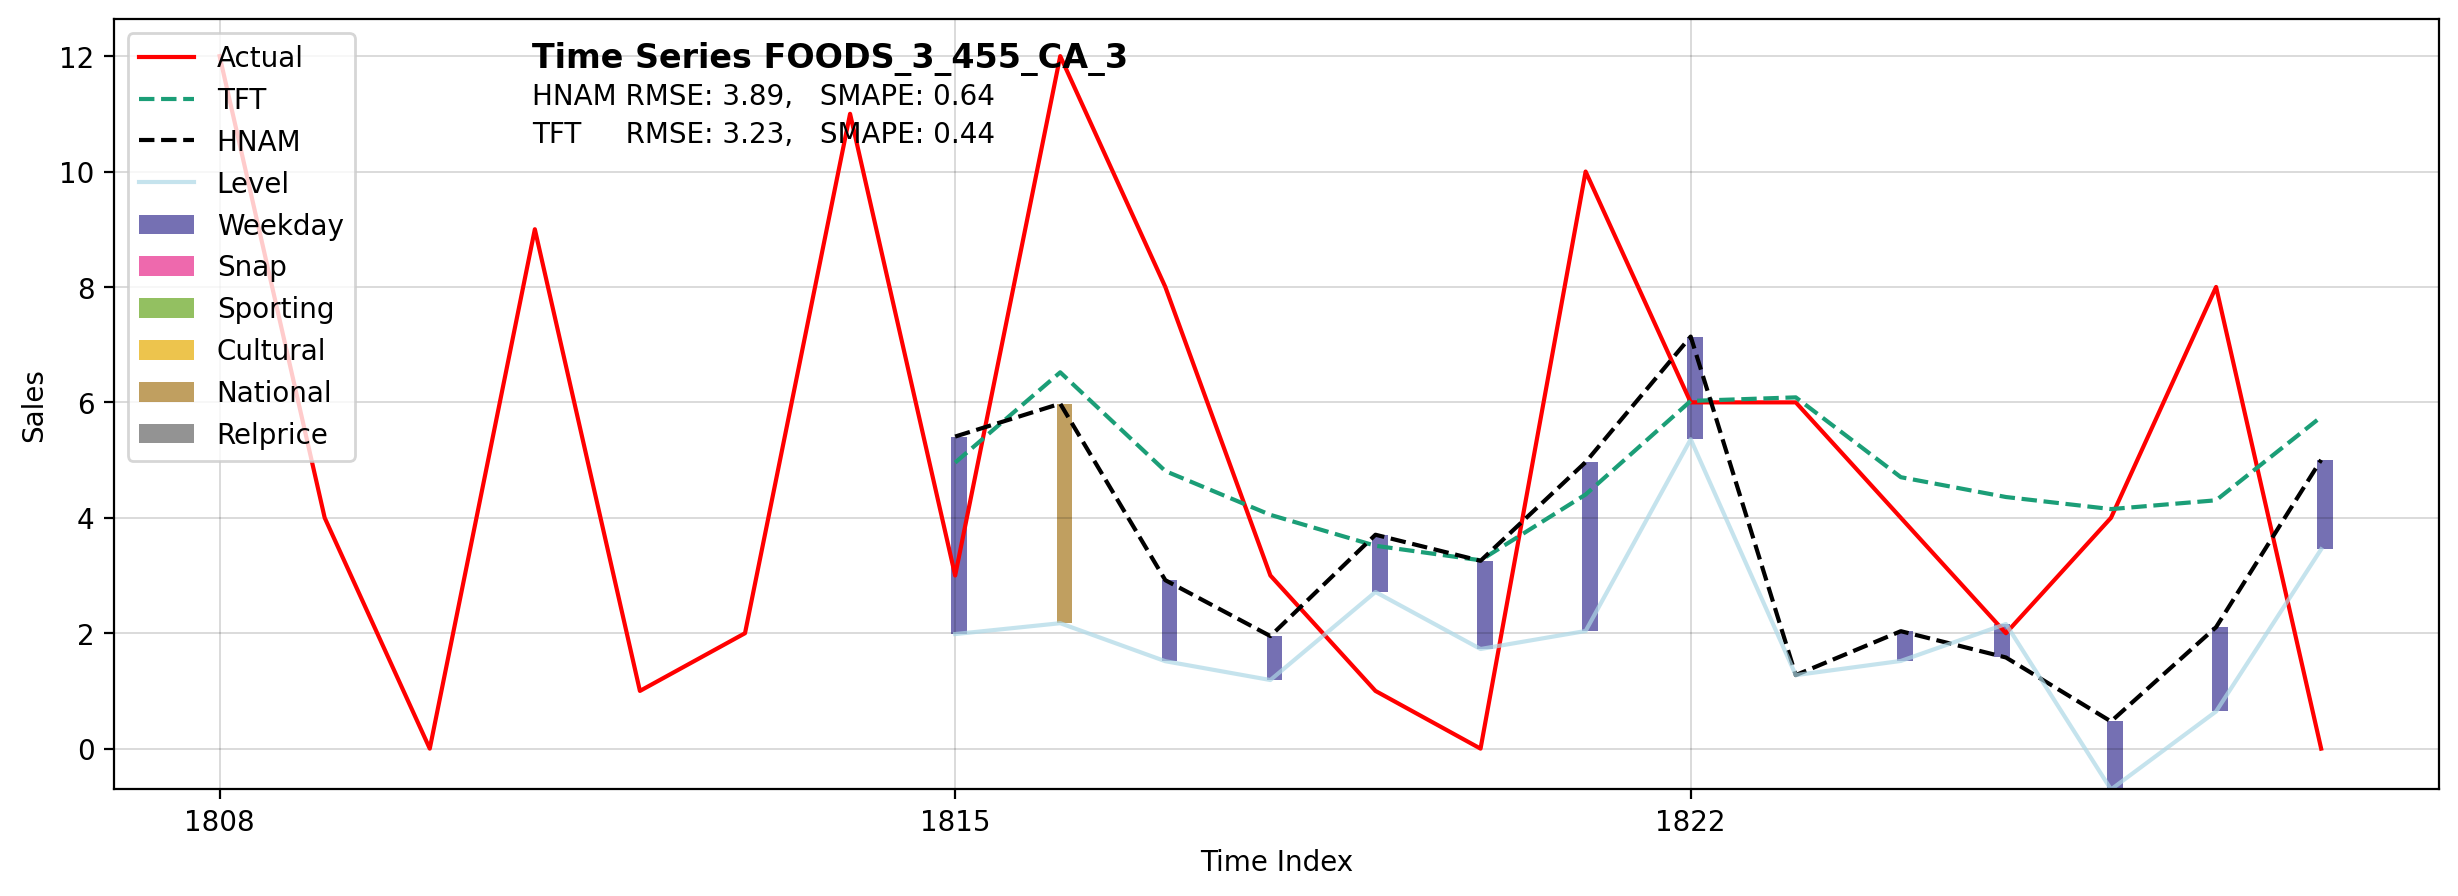

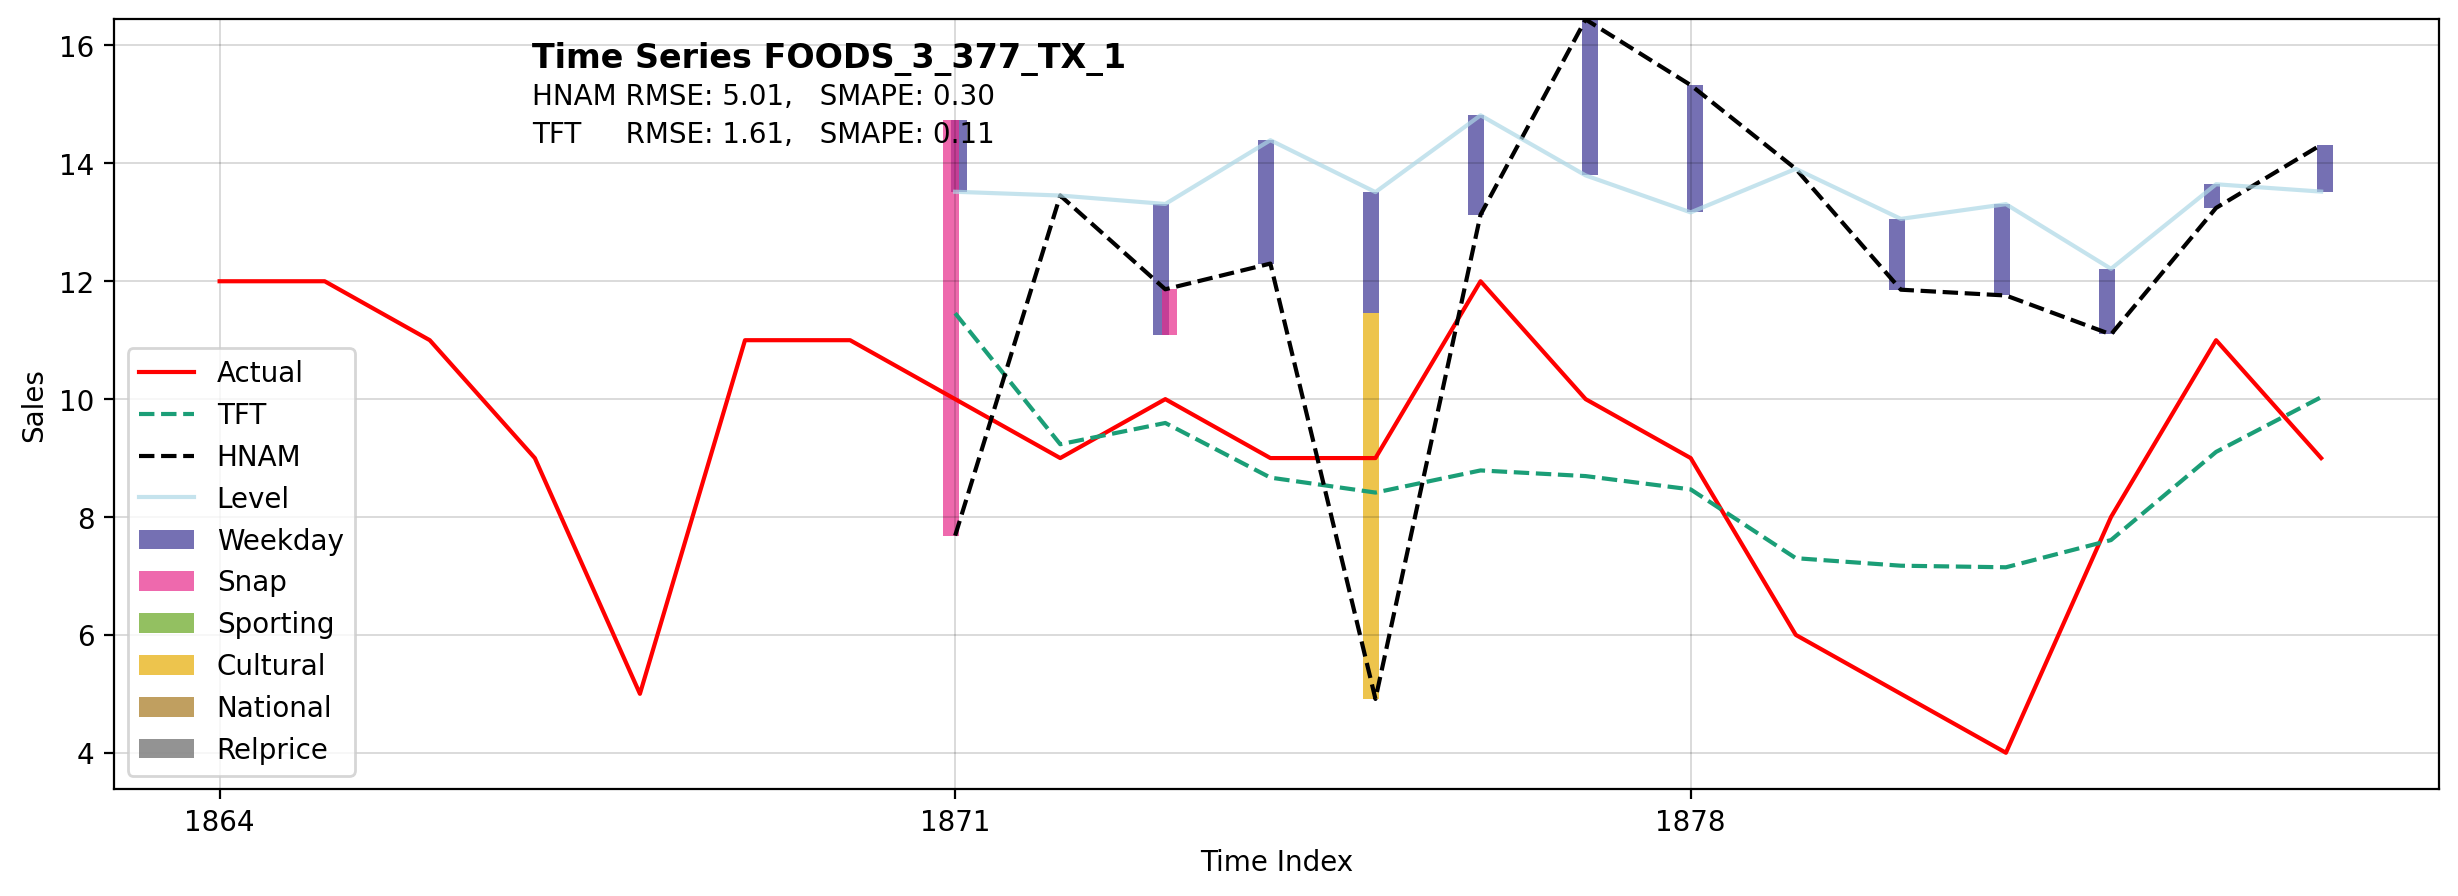

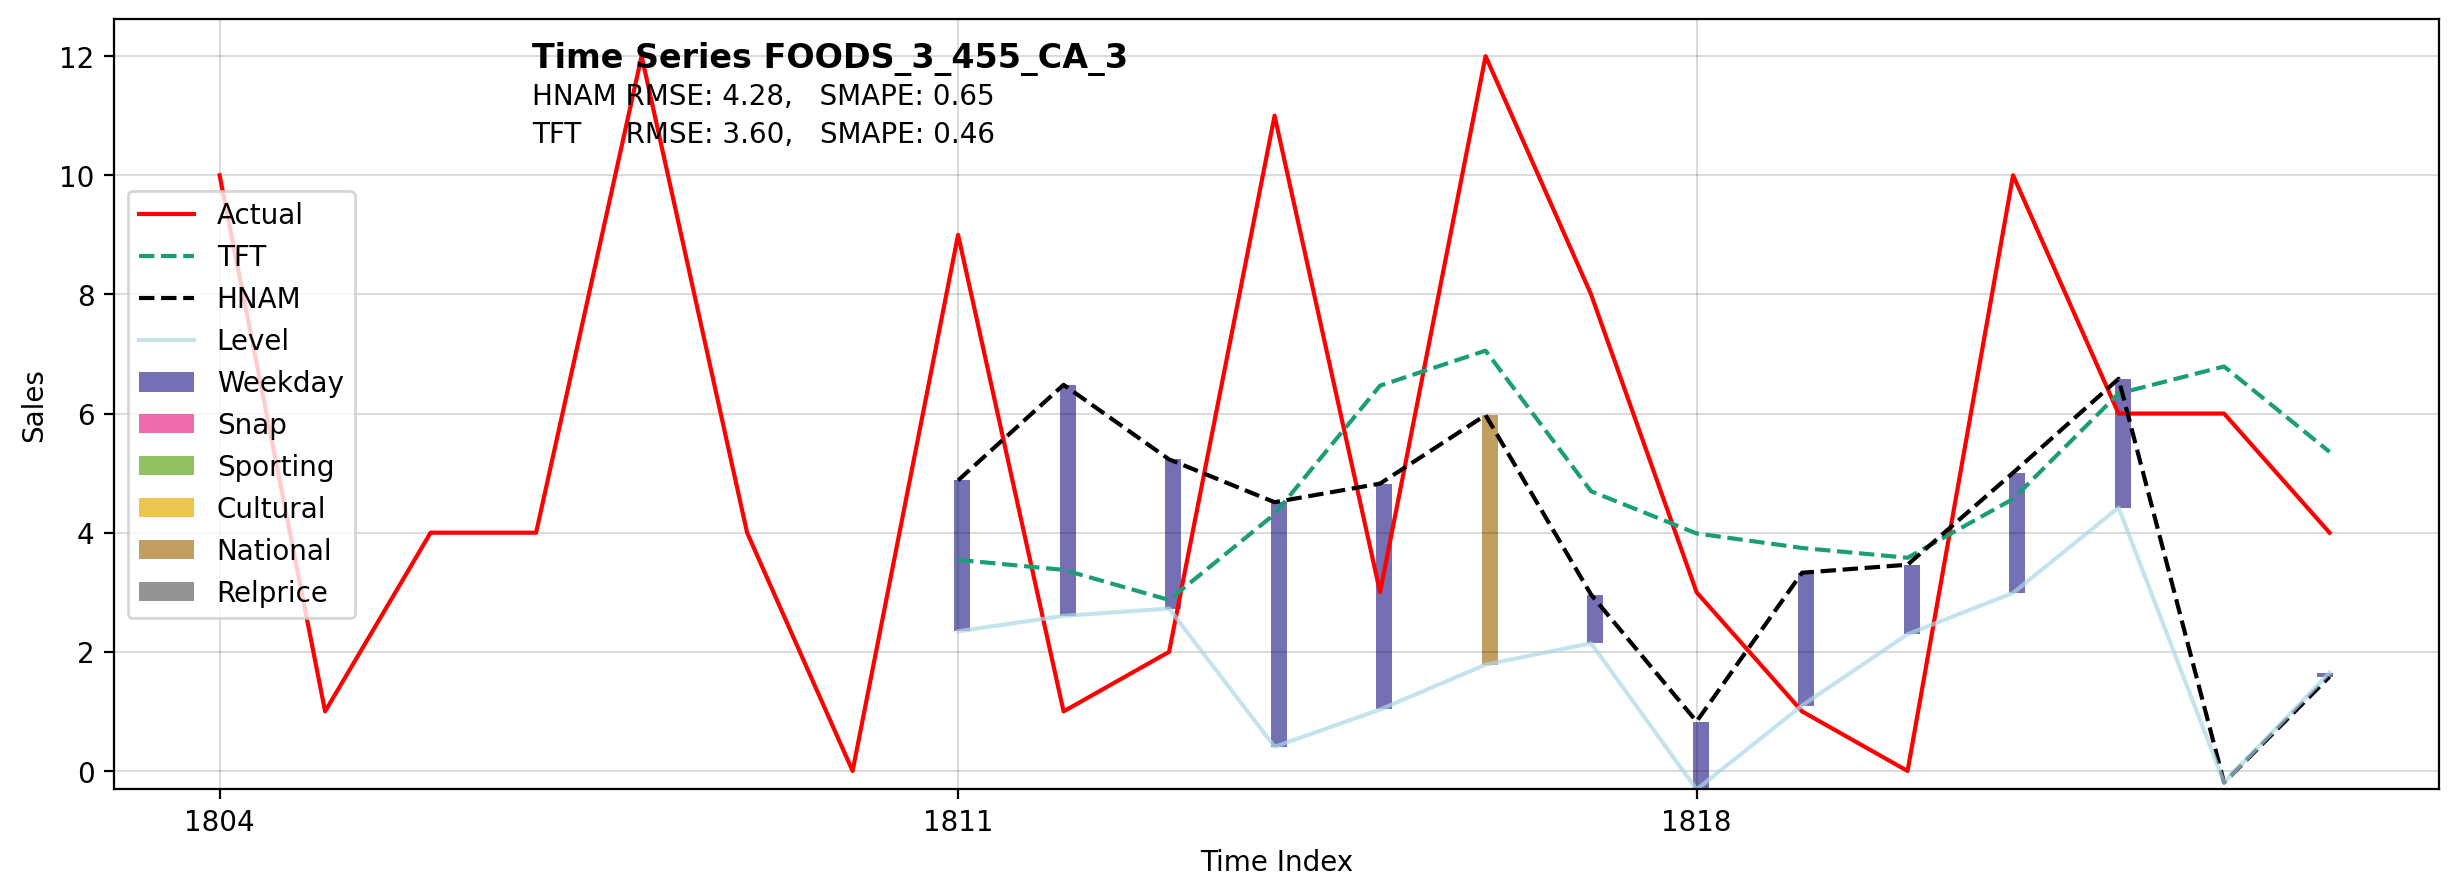

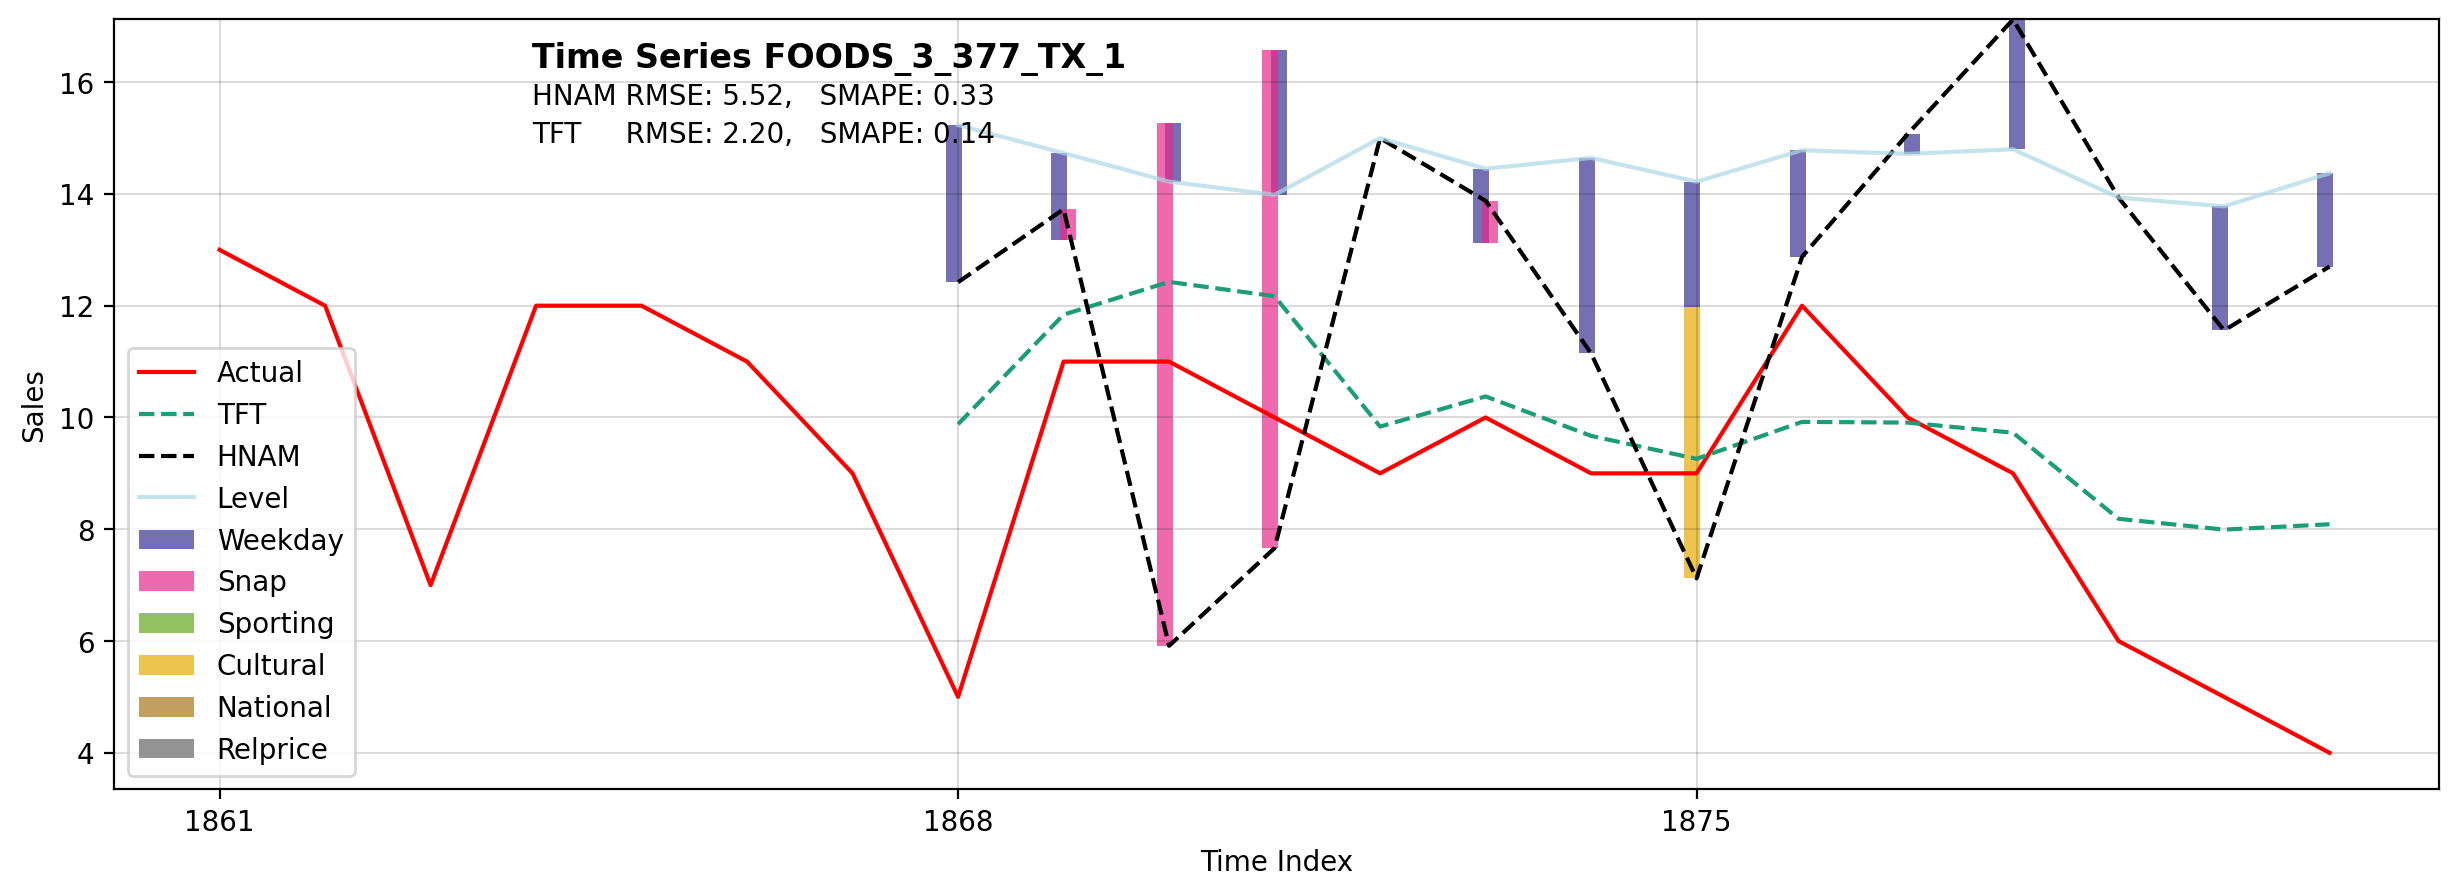

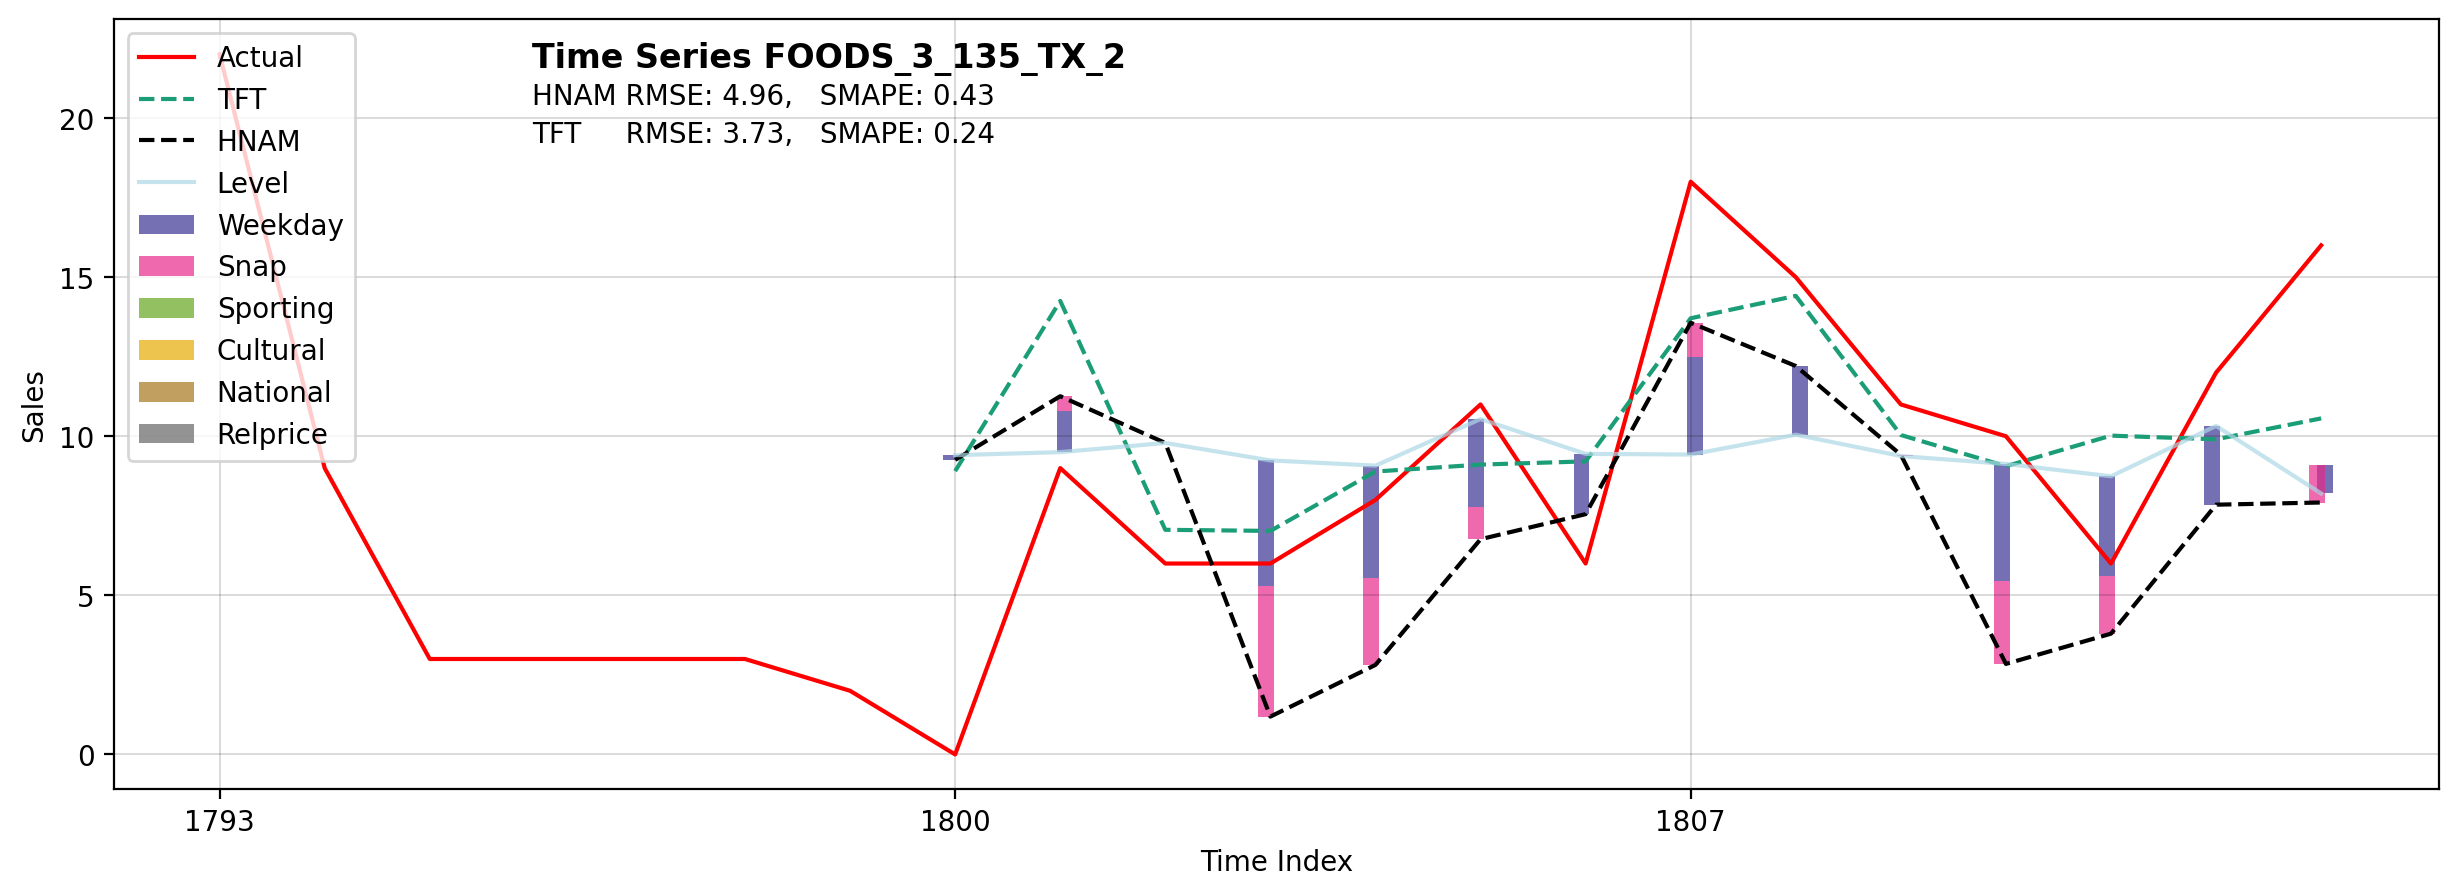

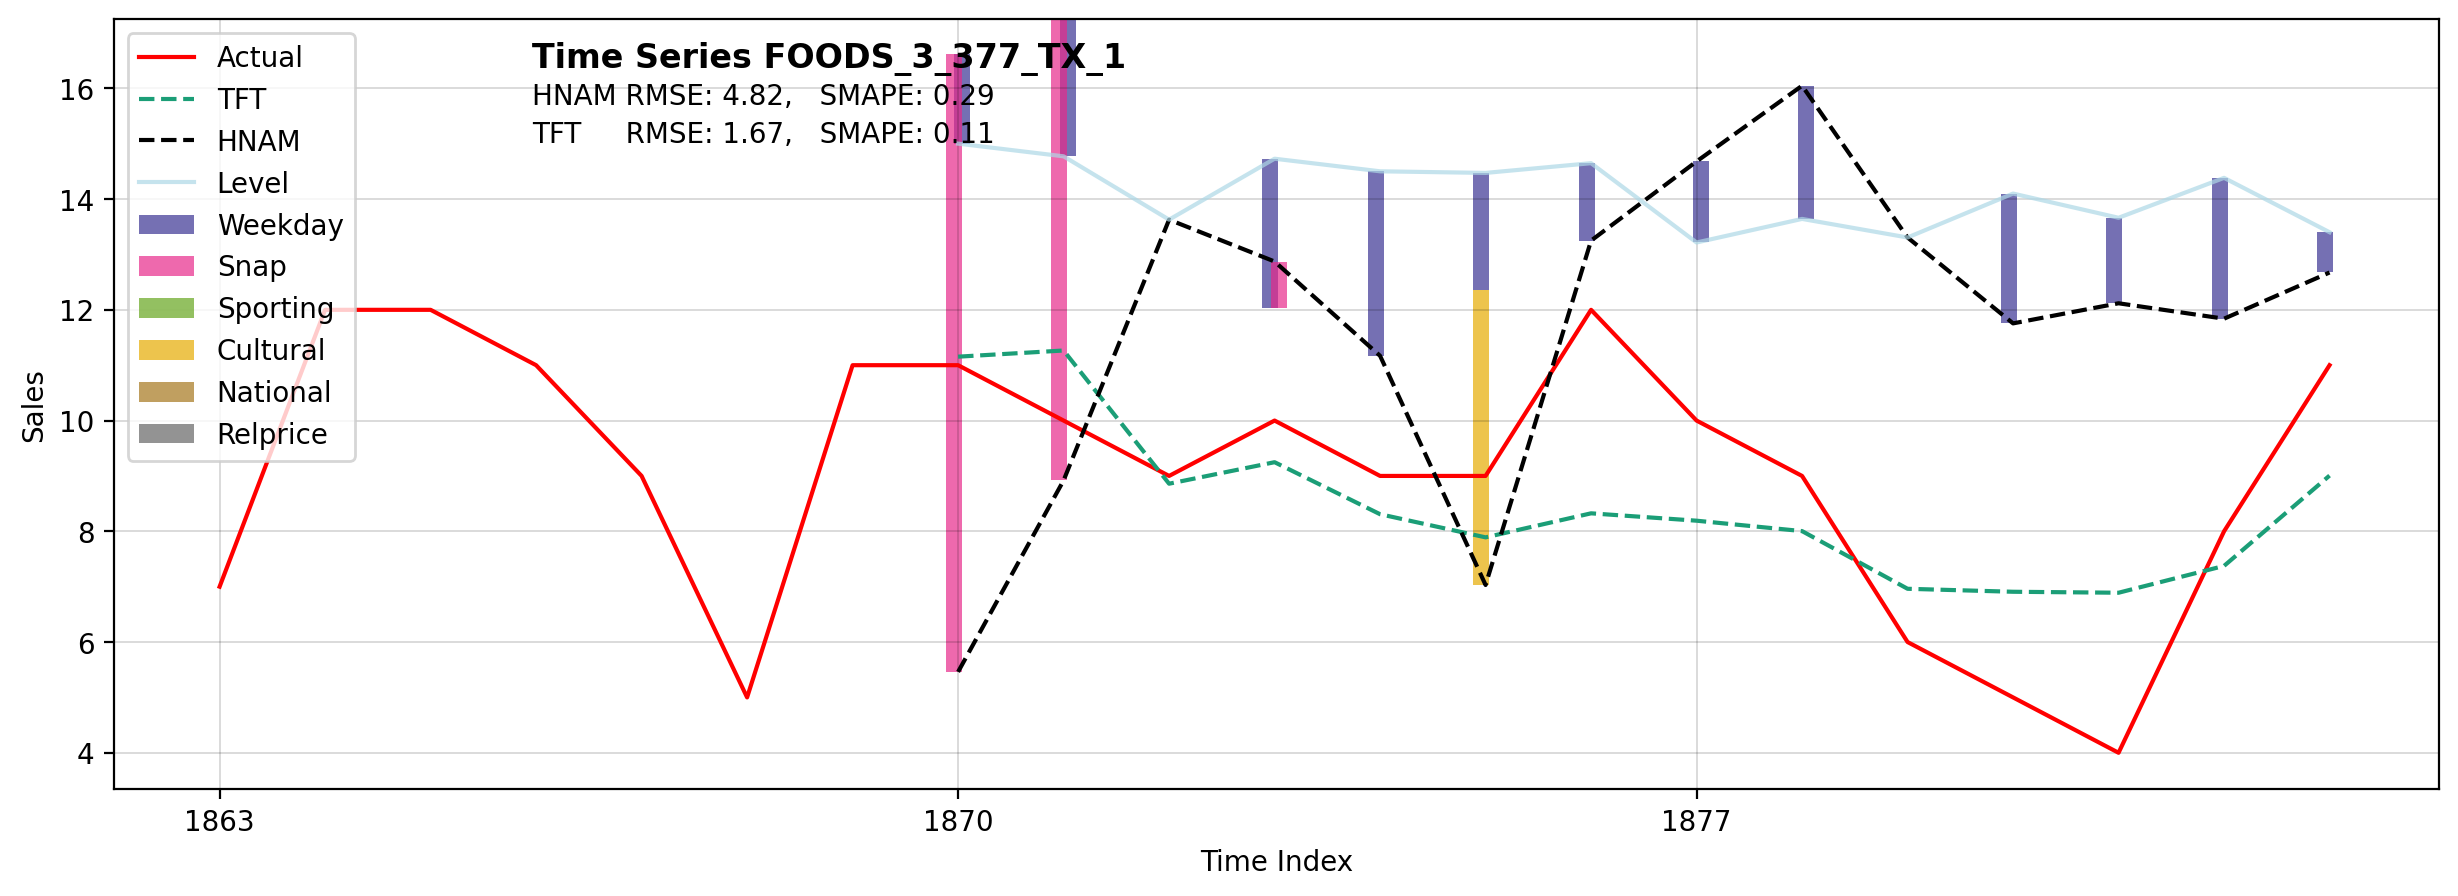

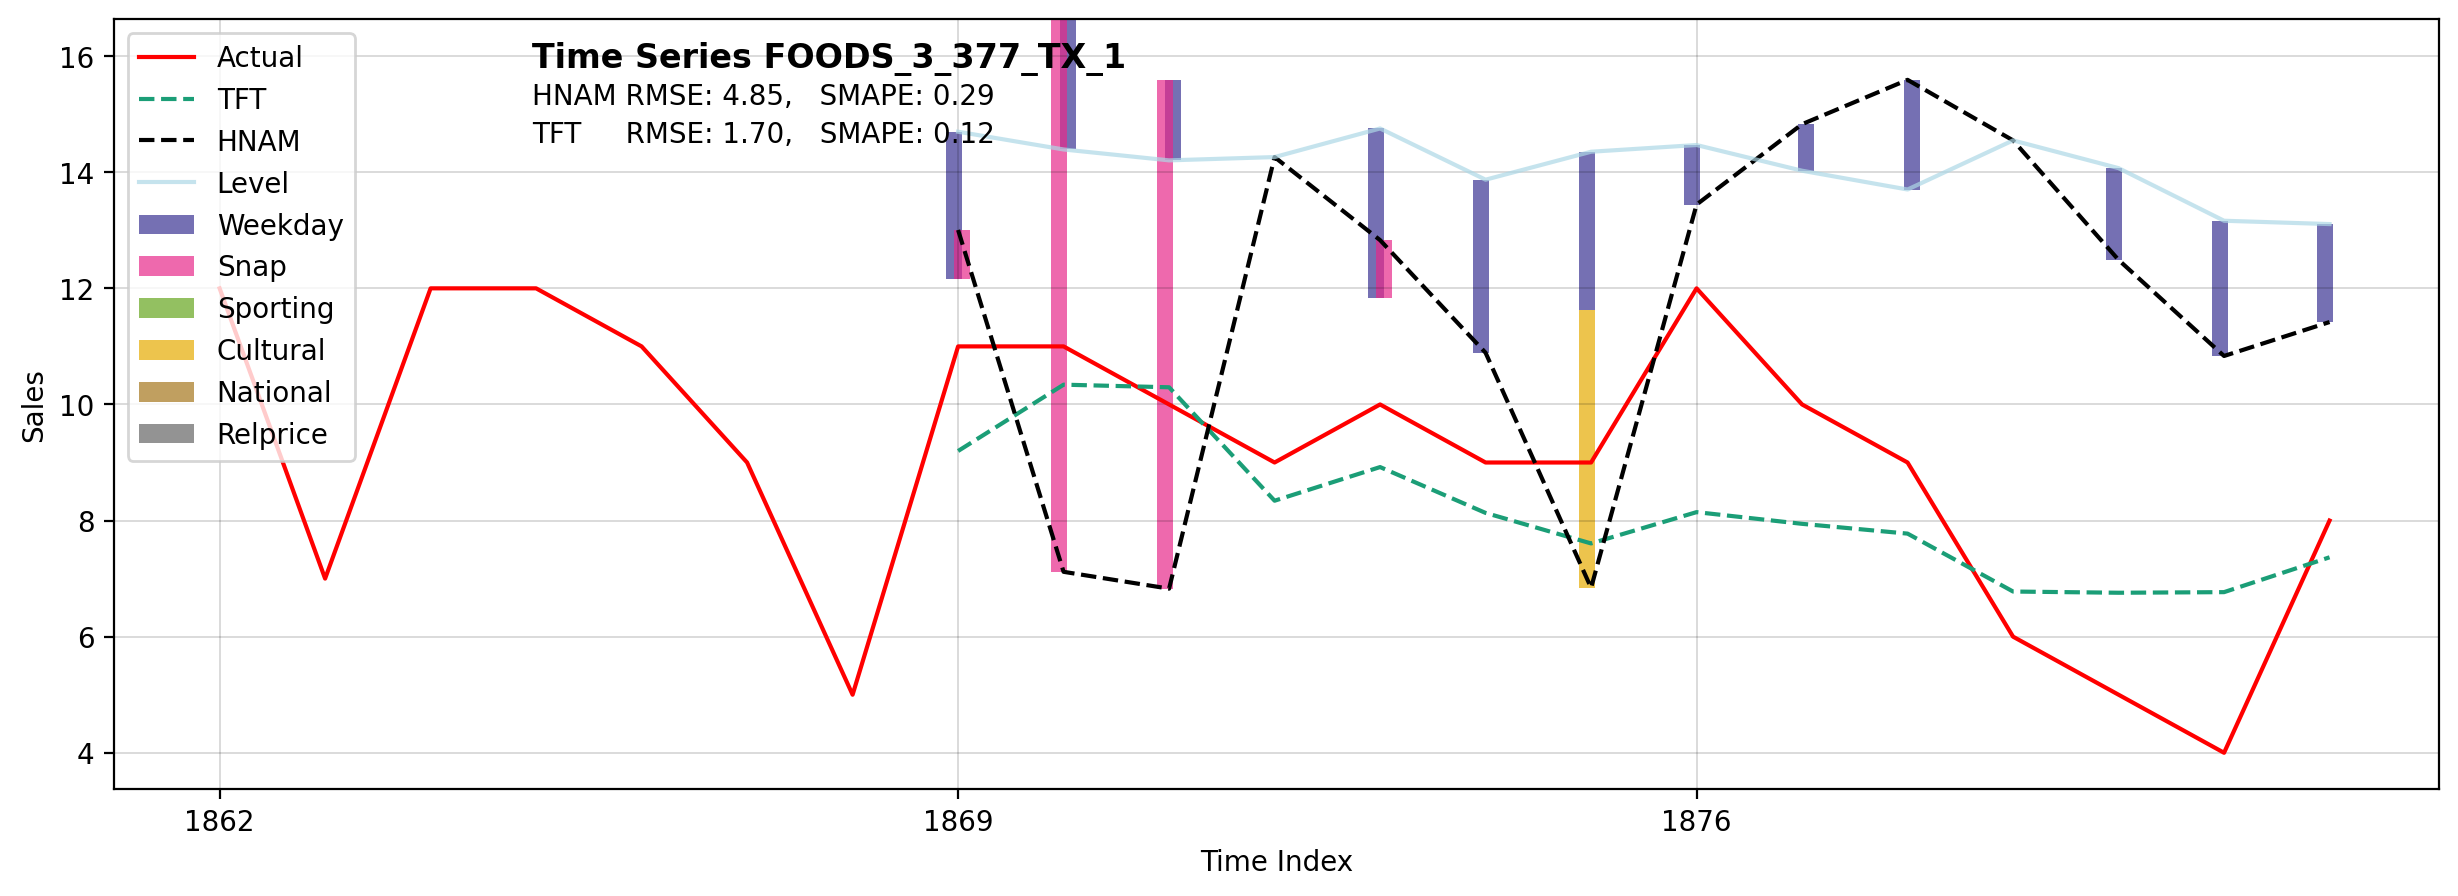

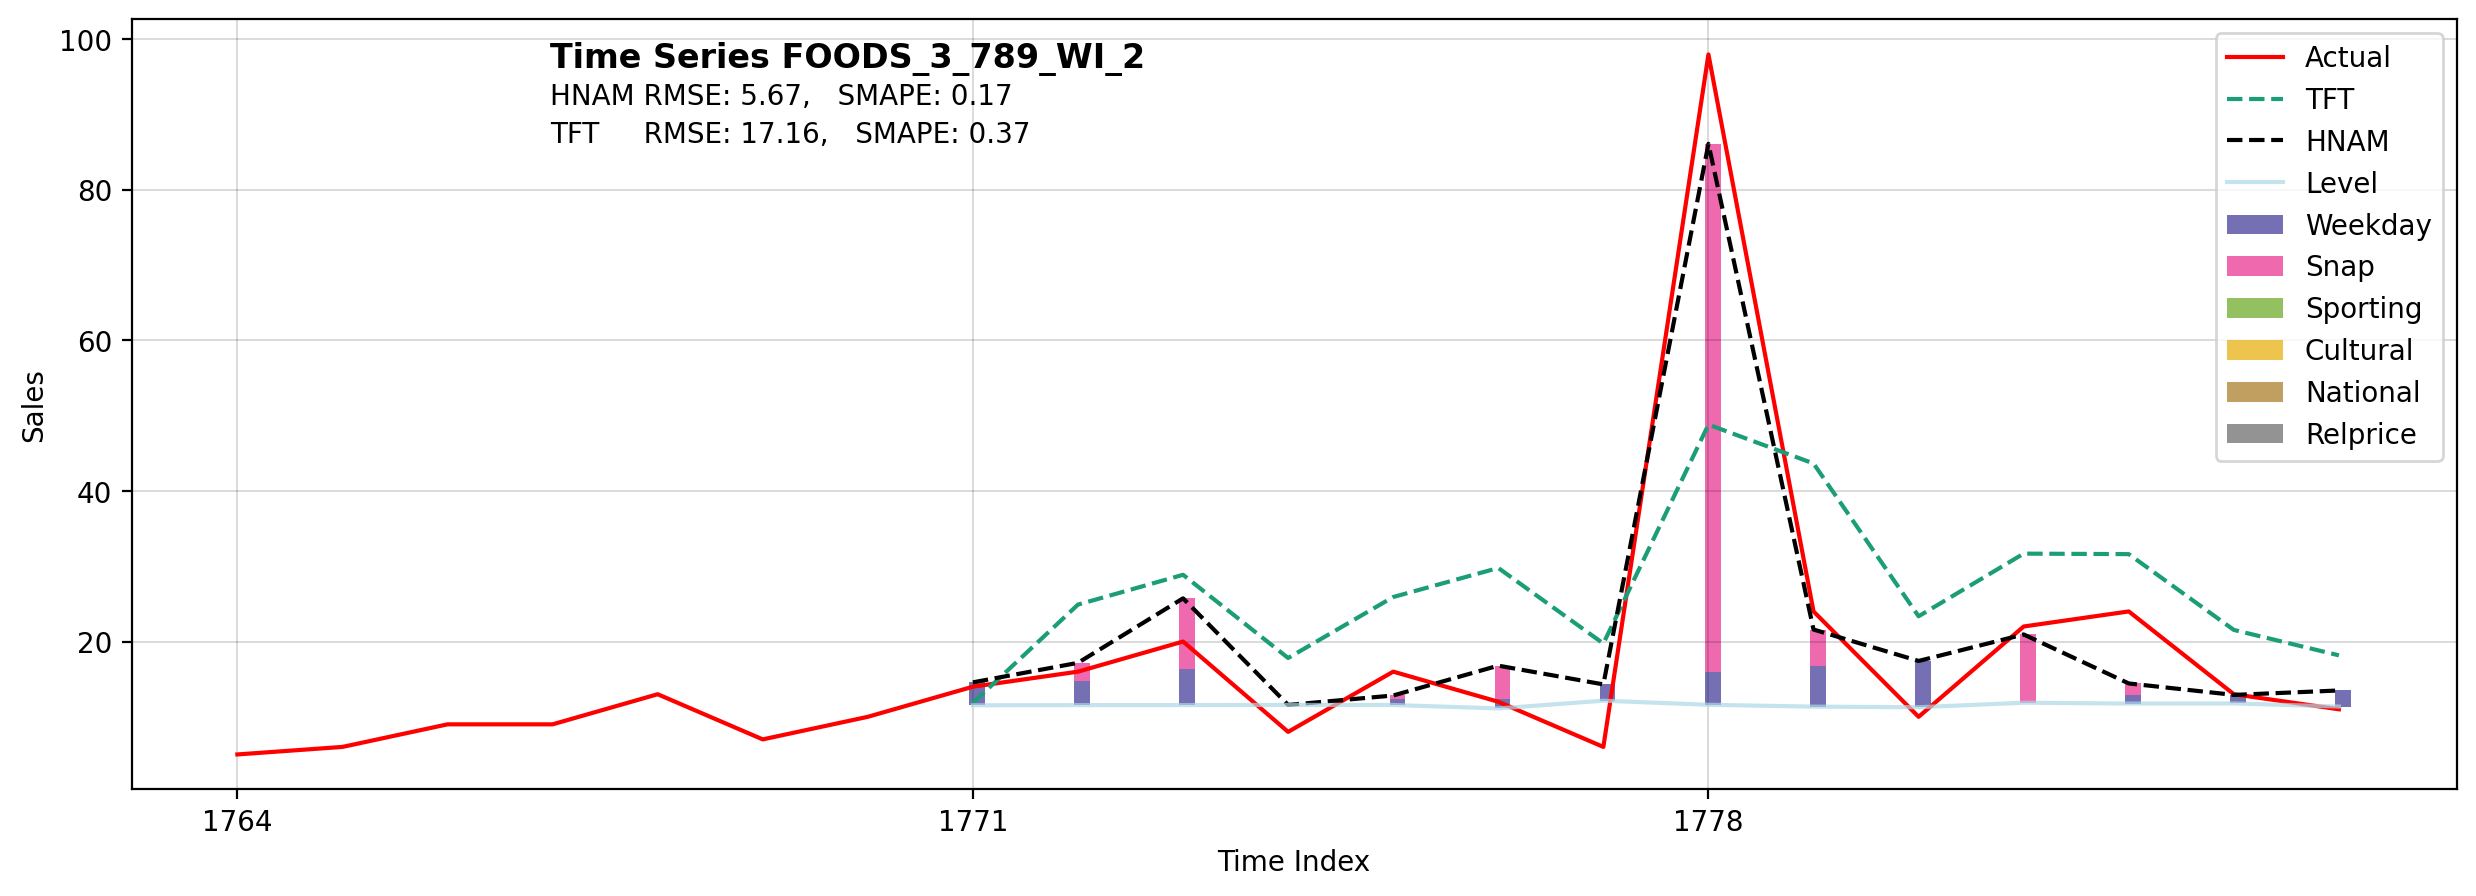

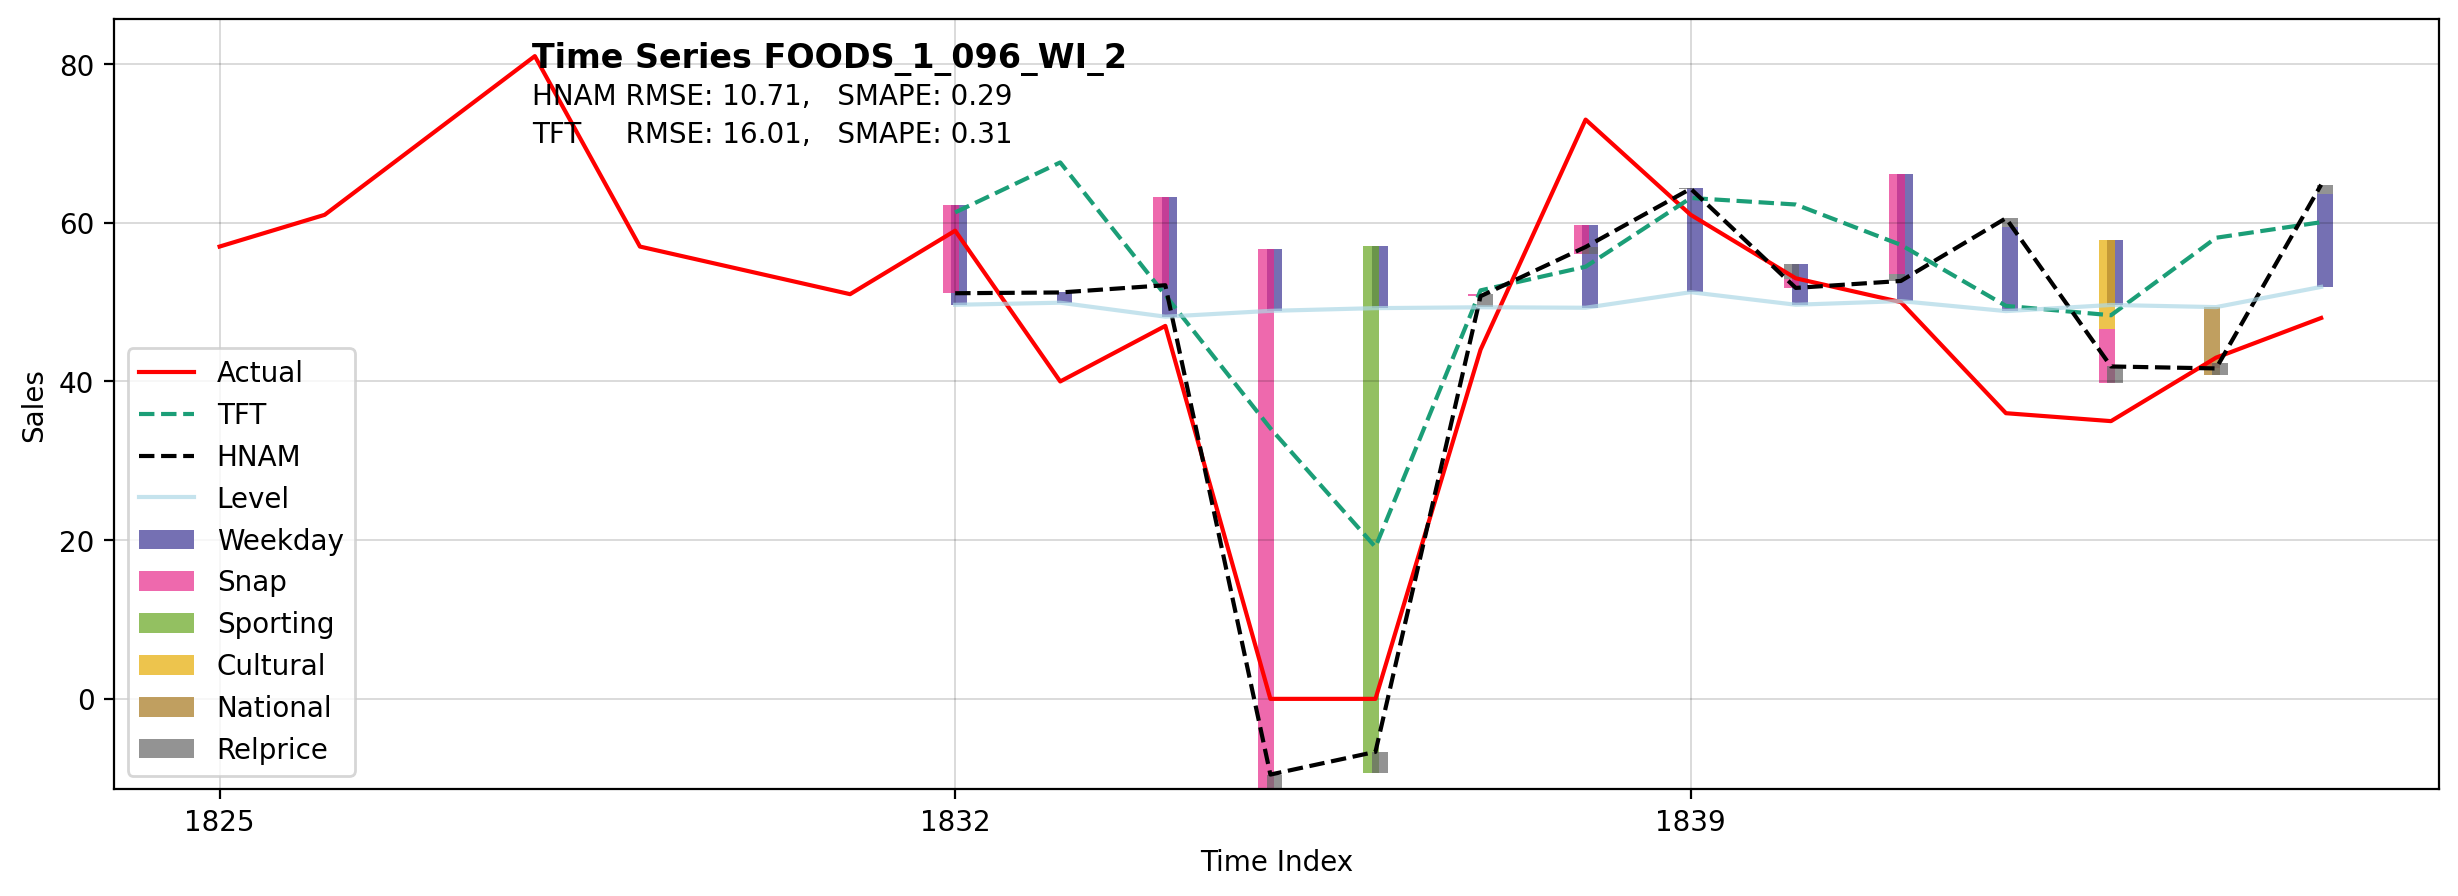

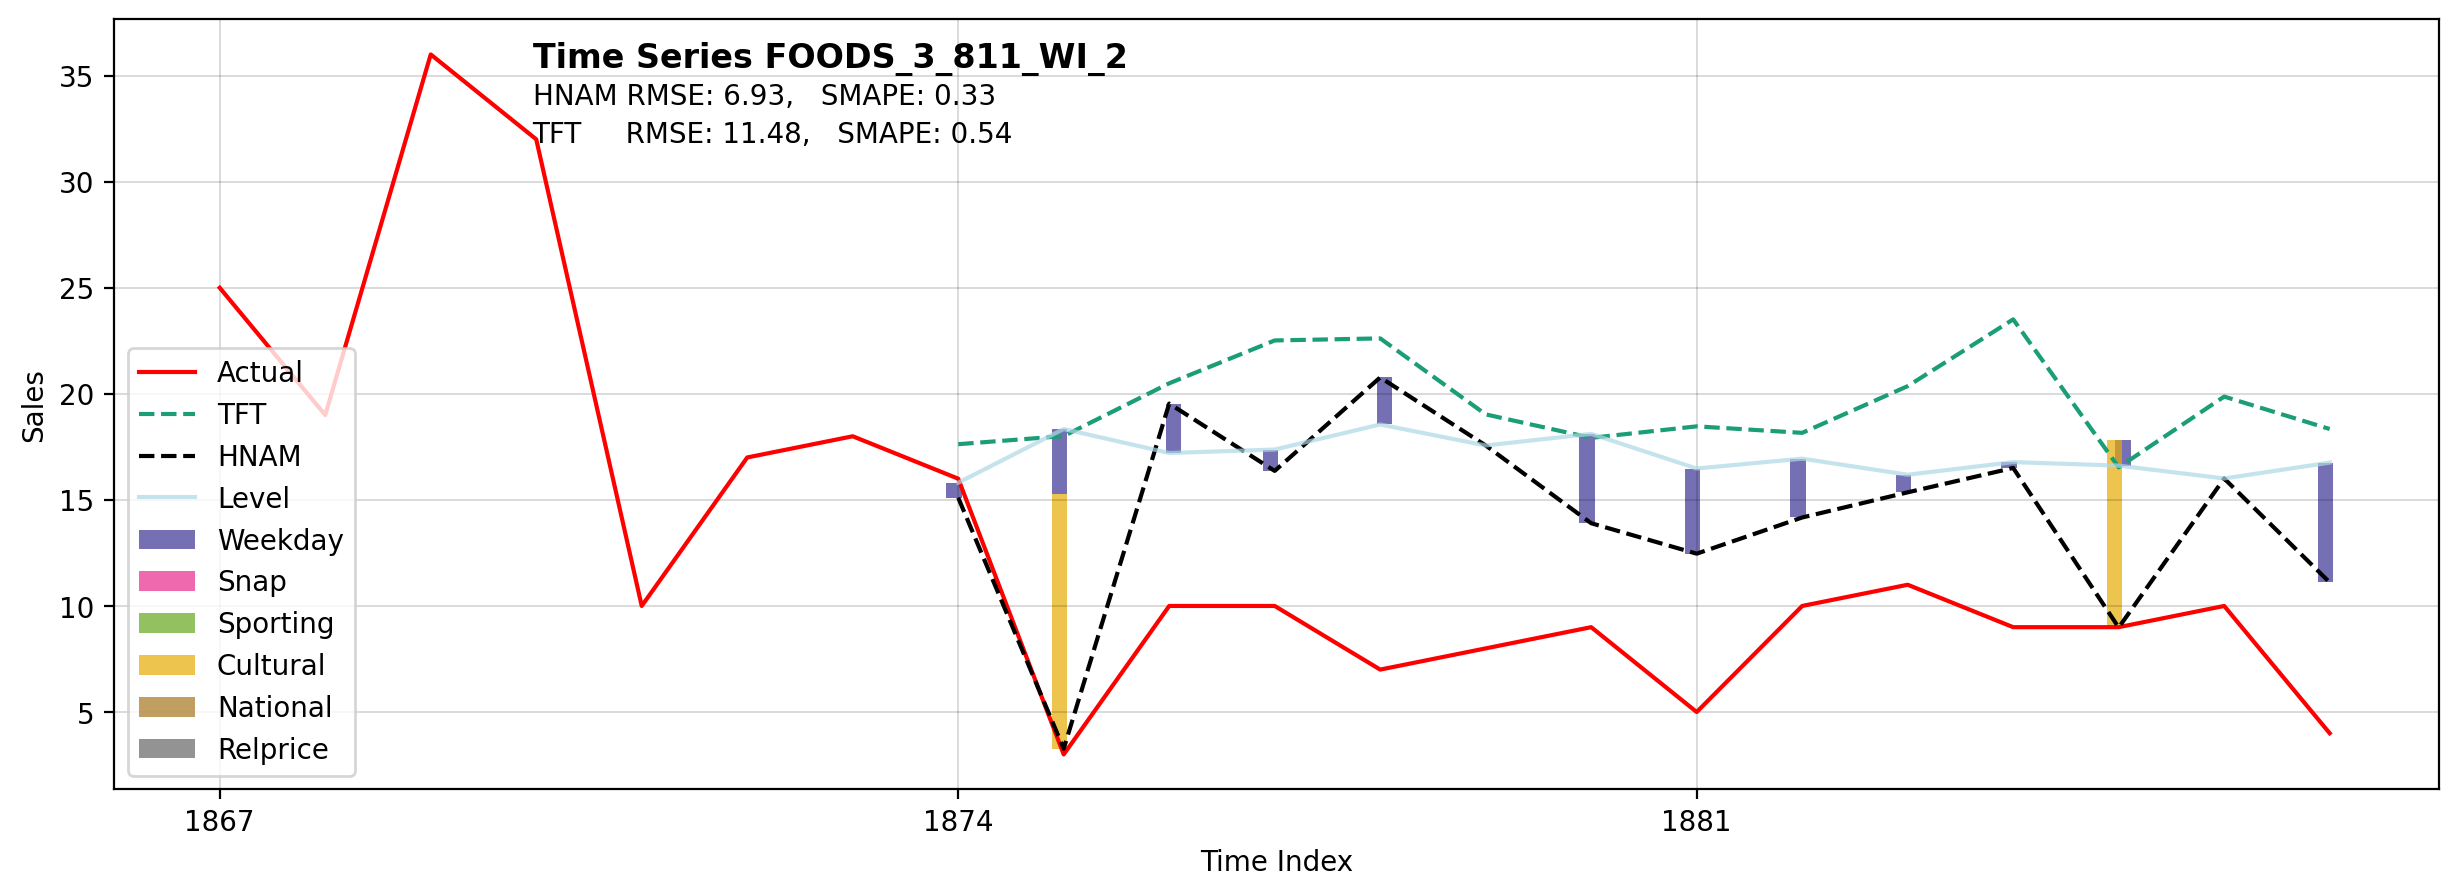

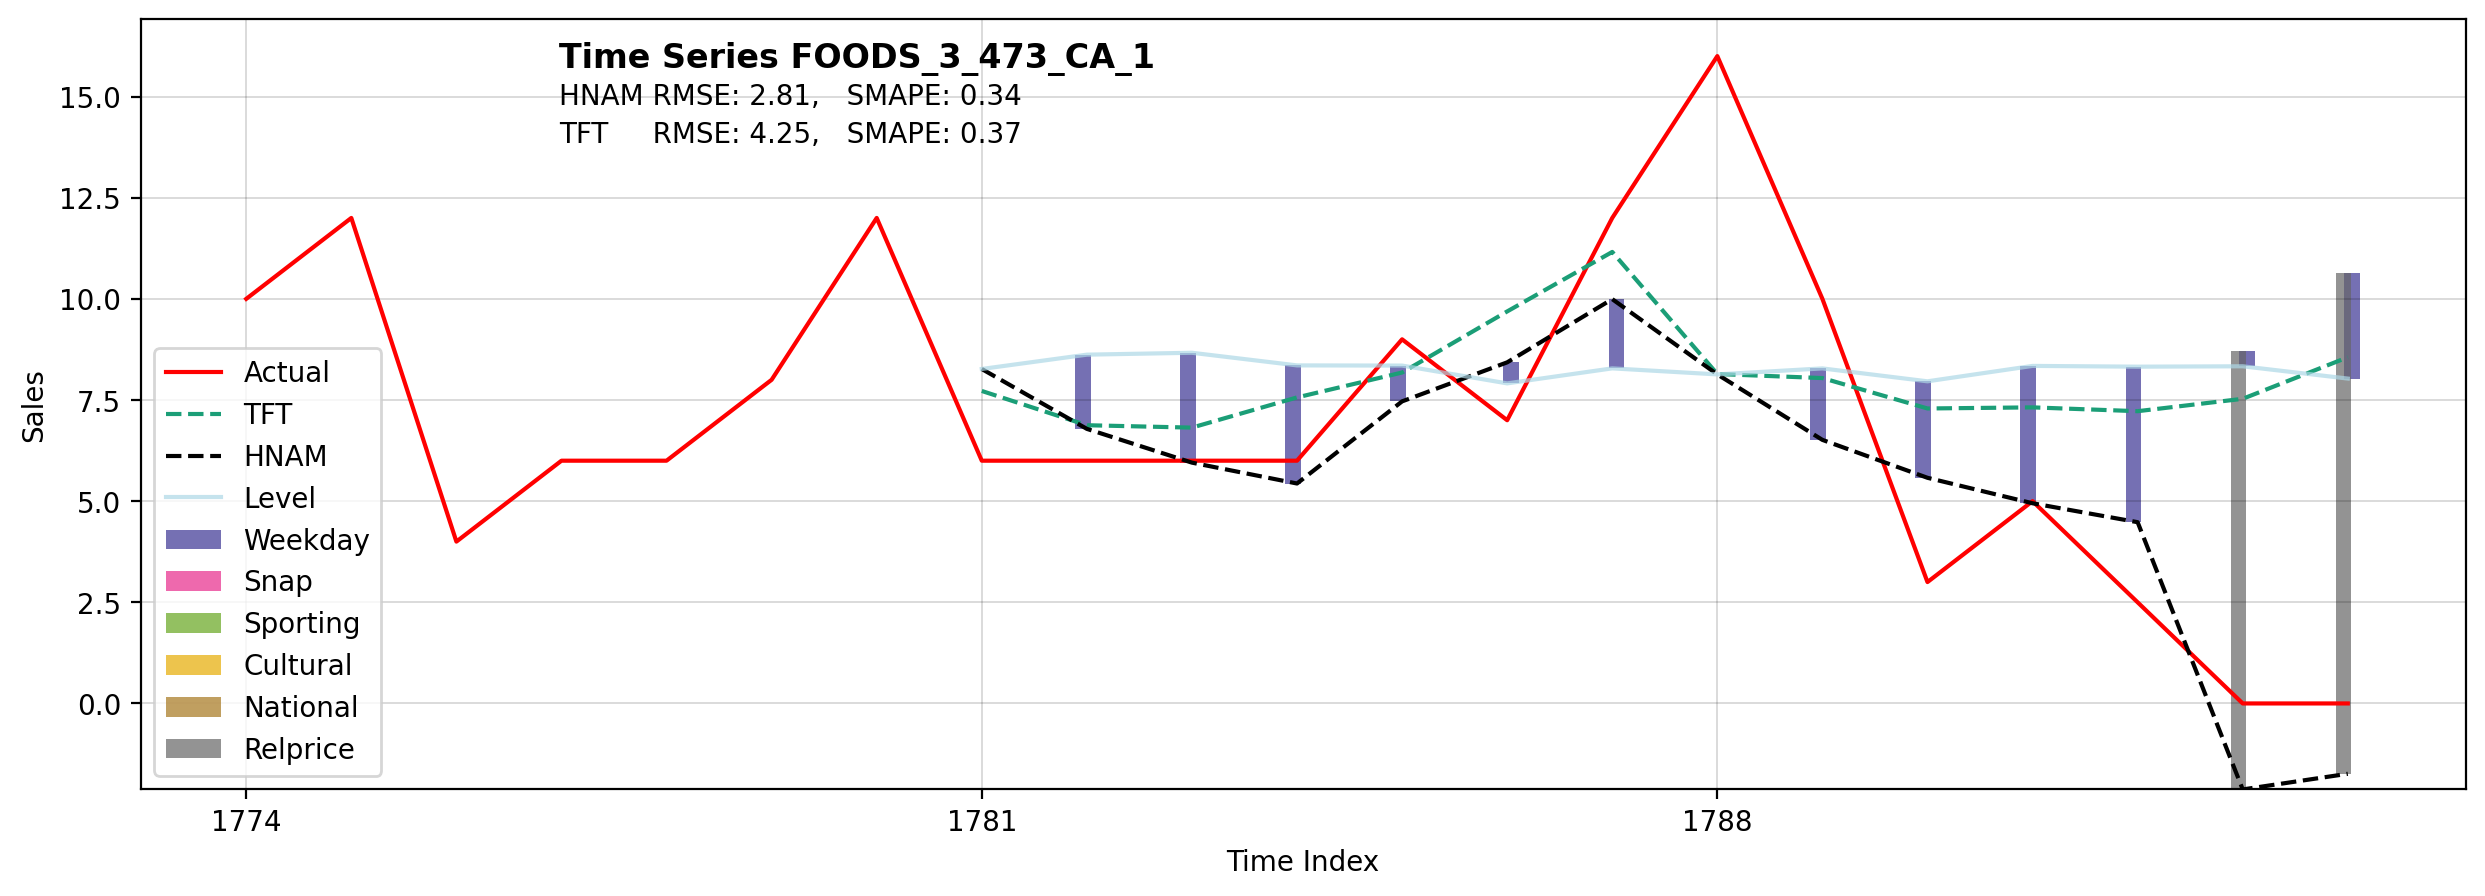

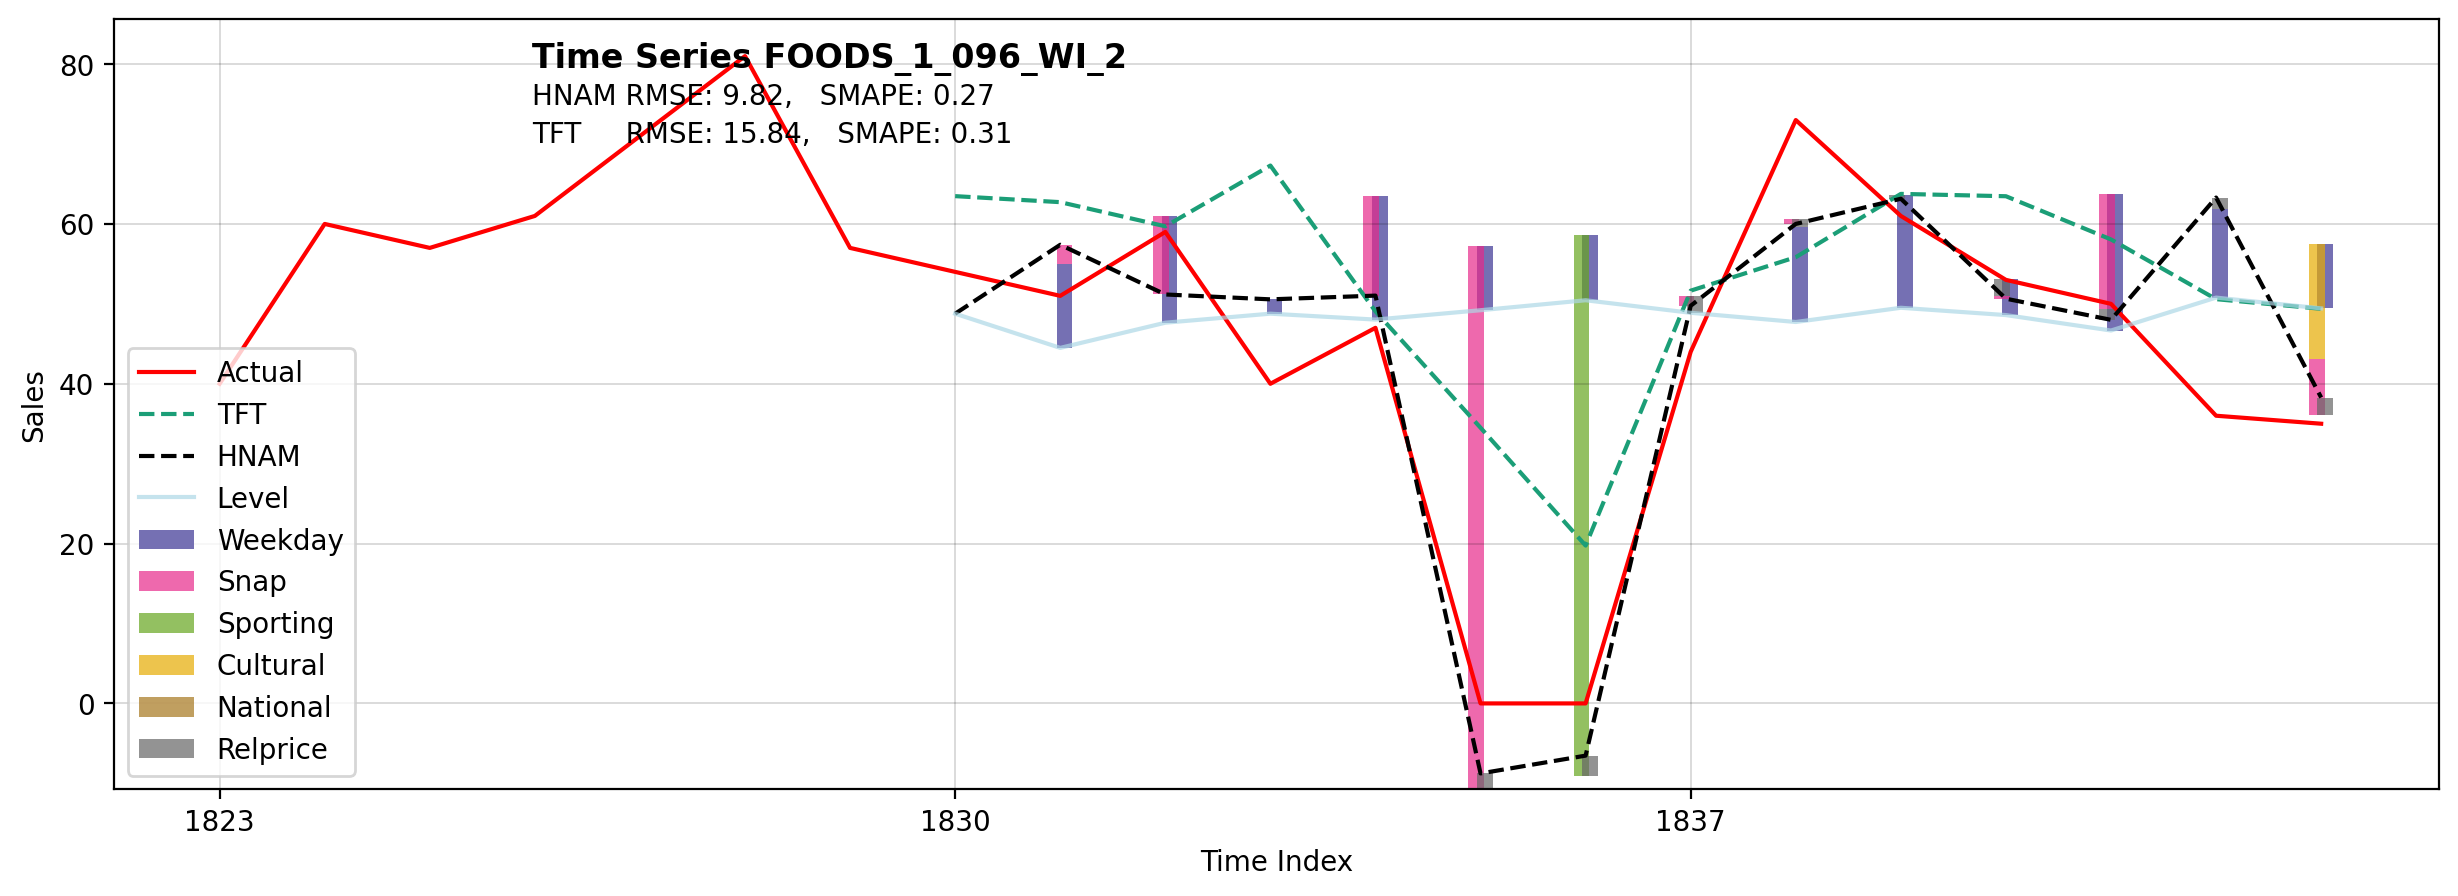

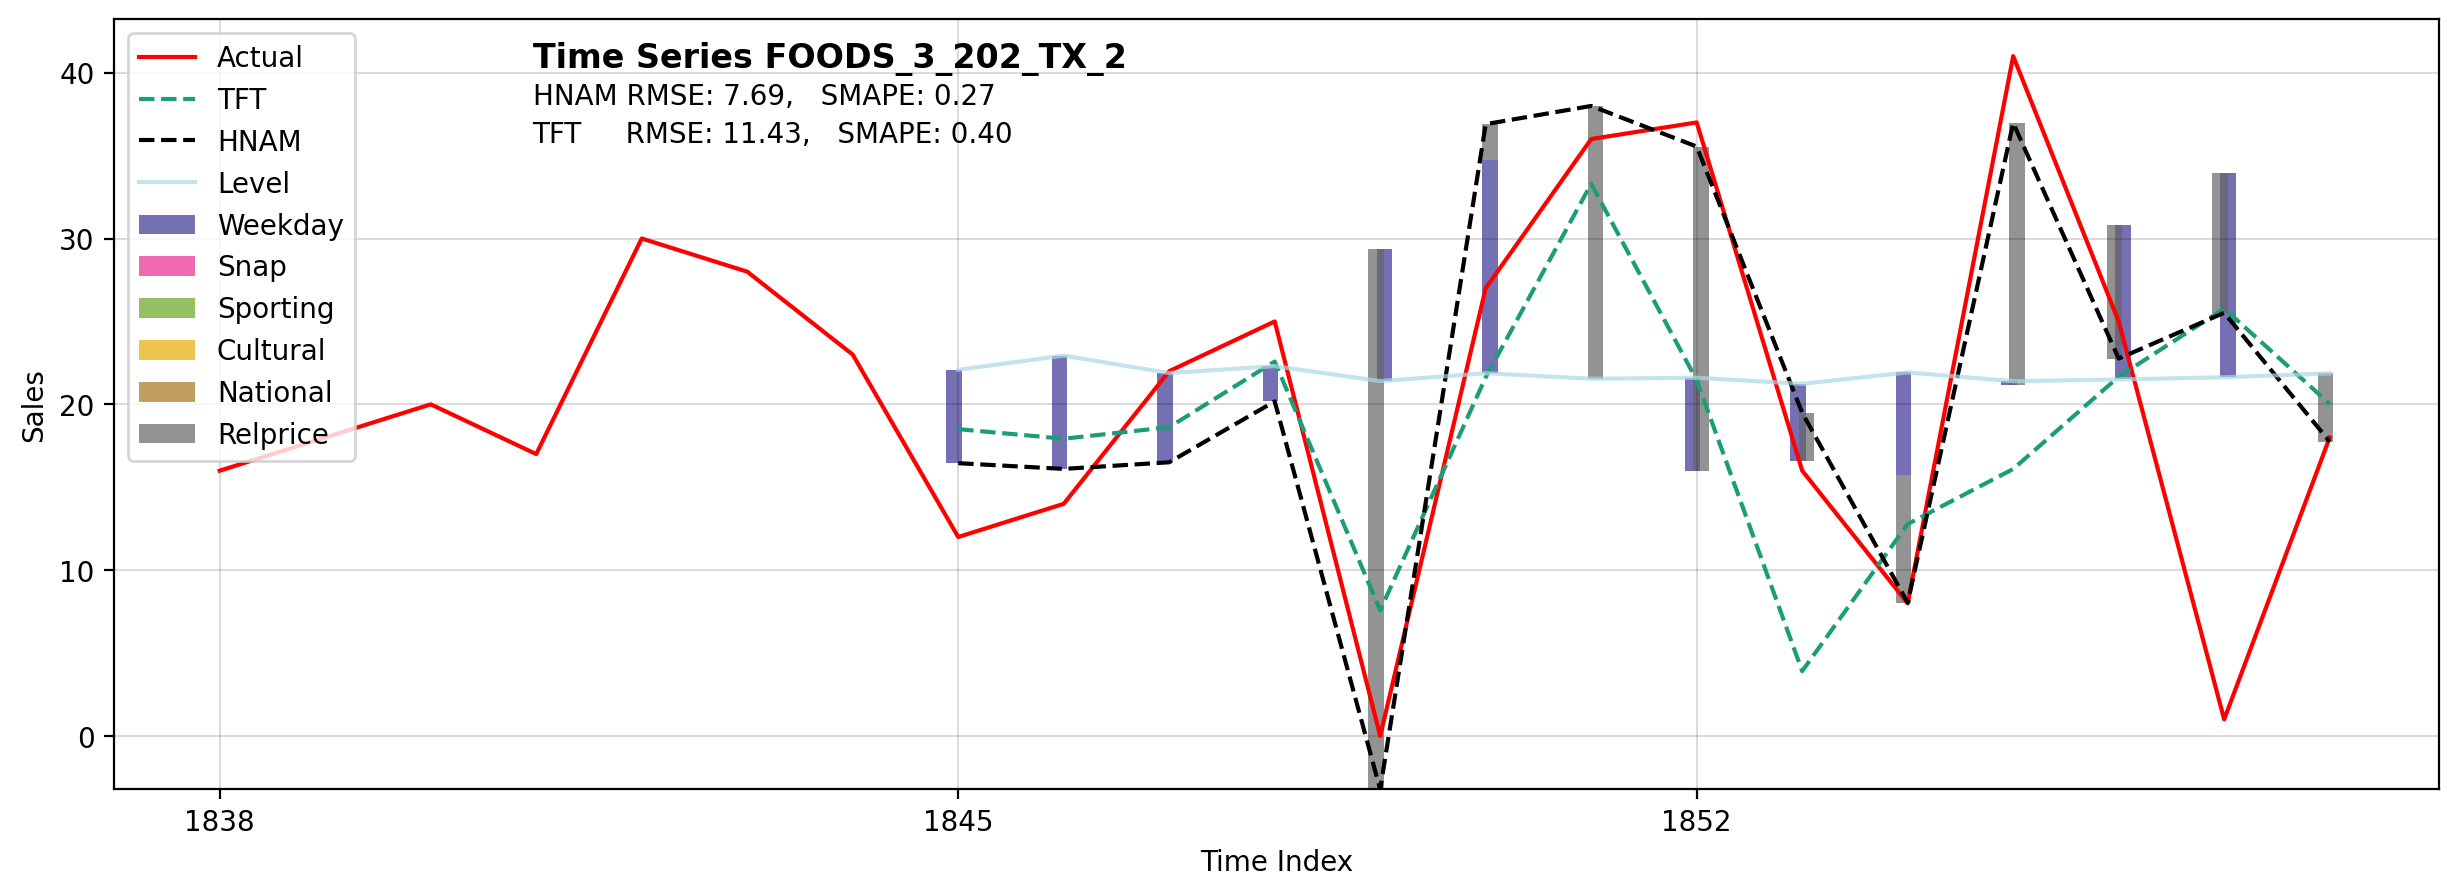

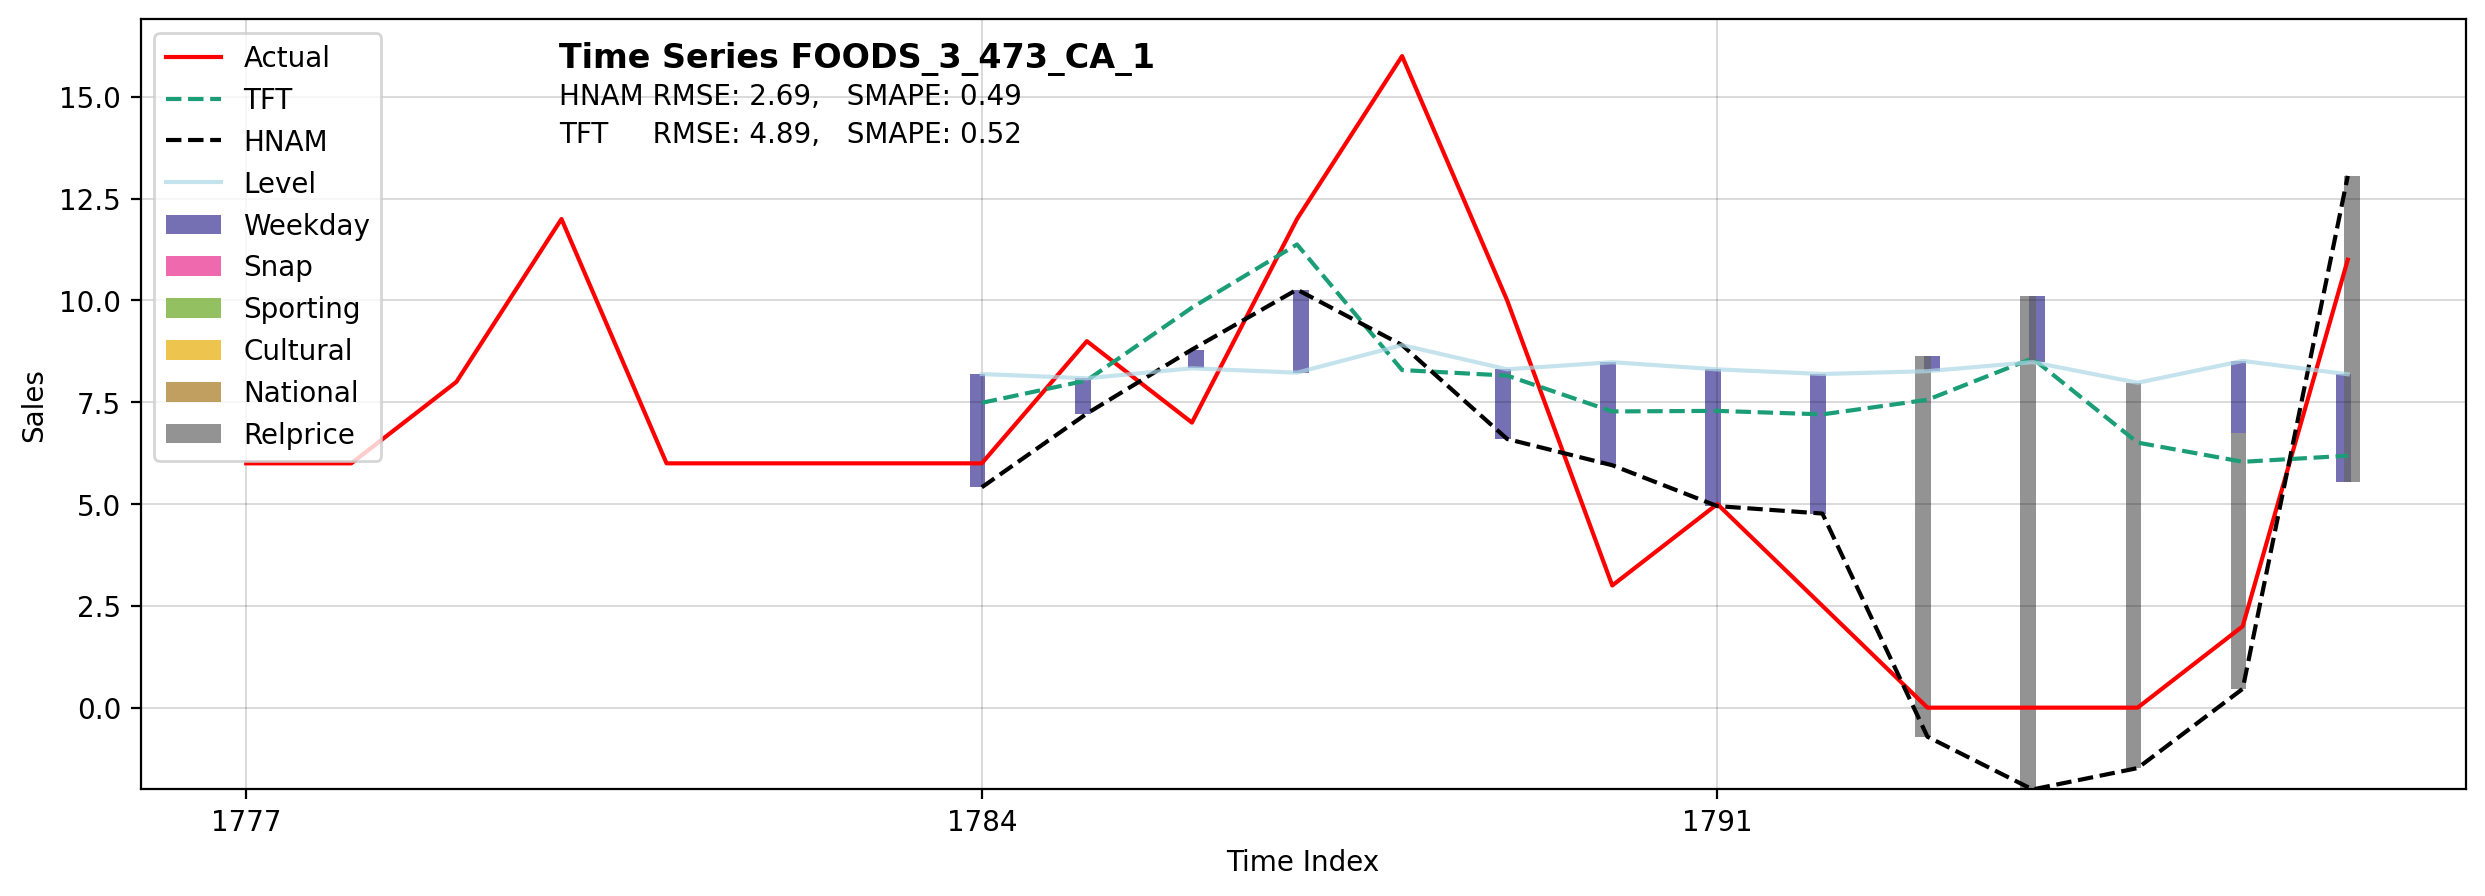

In [4]:
huge_diff = pd.read_pickle(f'tft_hnam_diff_{DATASET.lower()}.pkl')
for i in list(range(10)) + list(range(-11,-1)):
    ts      = huge_diff.index[i][0]
    tidx    = huge_diff.index[i][1]

    plot_fc(ts,tidx,history=7,f=7)

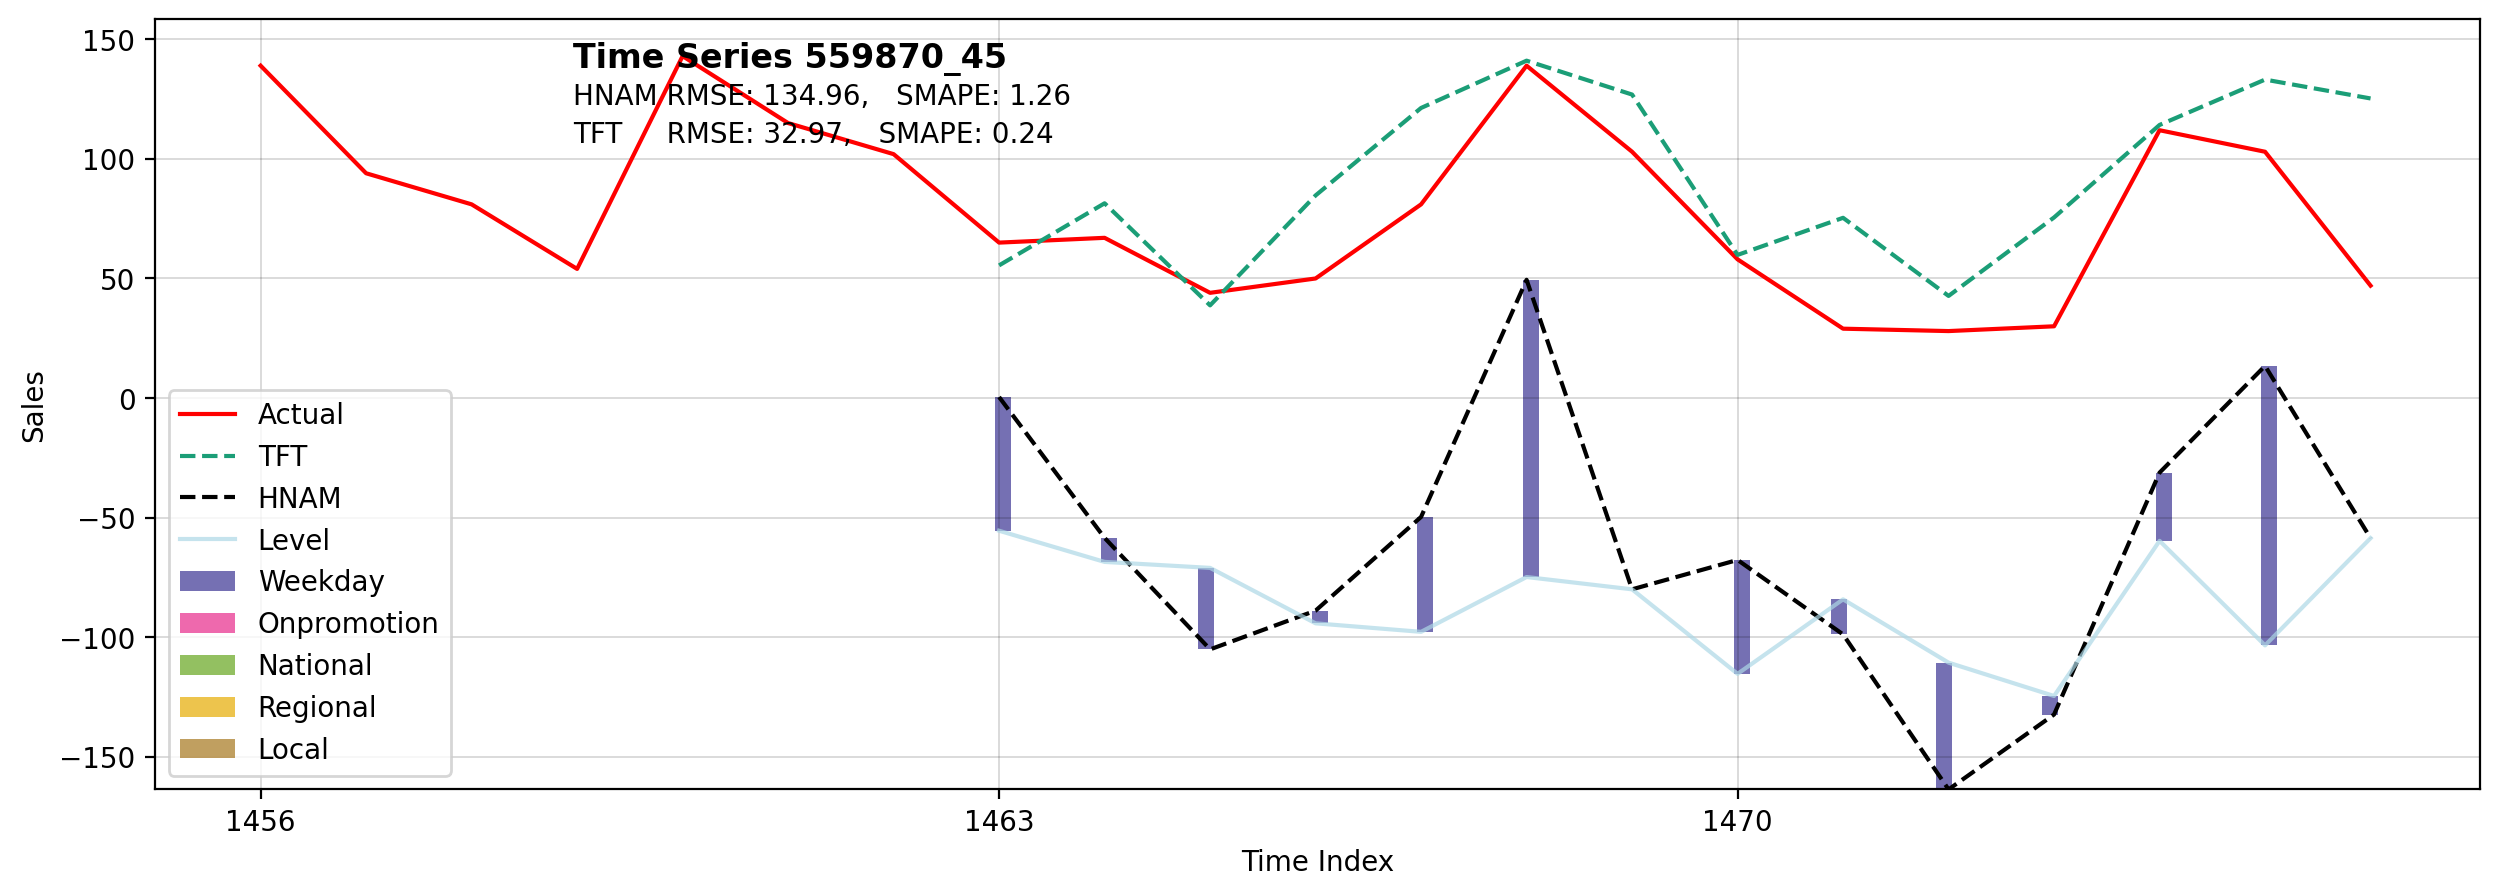

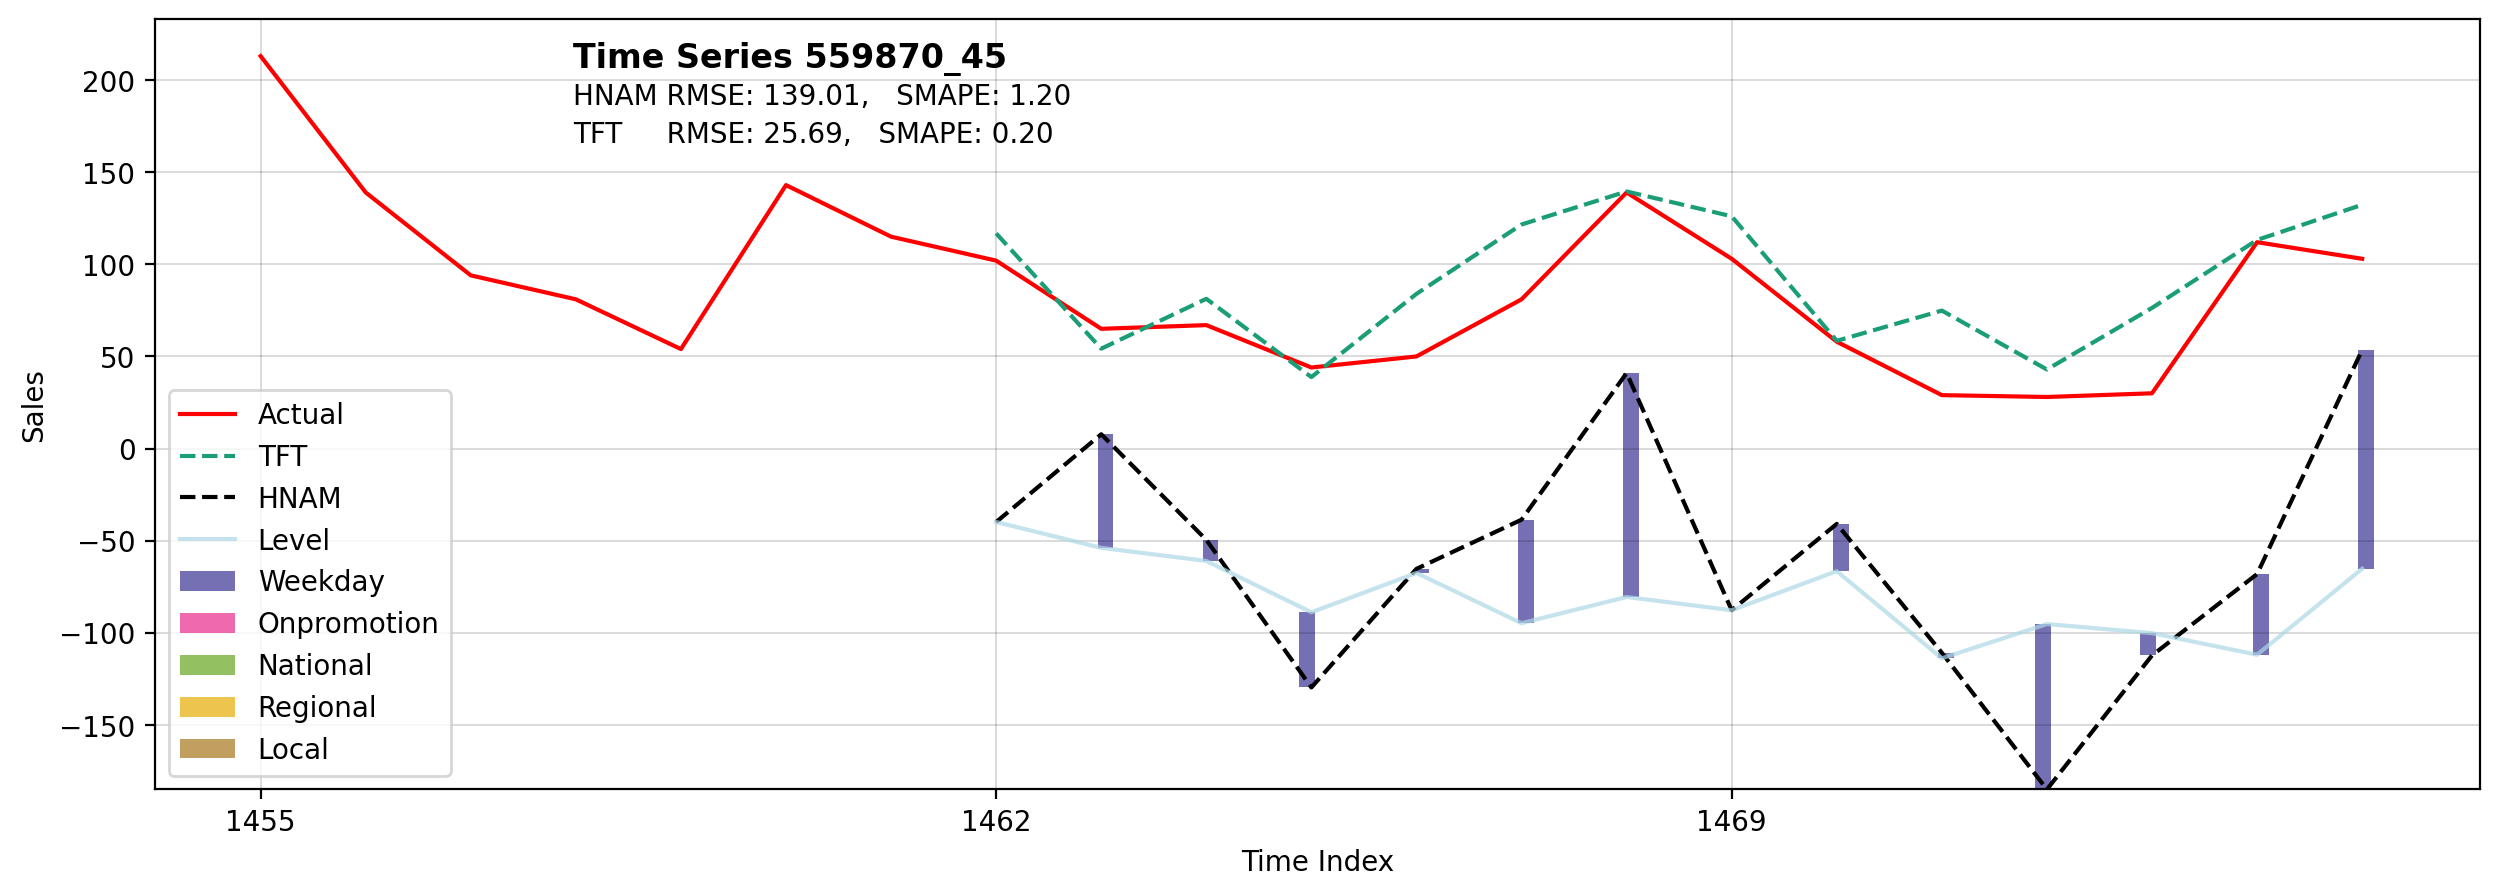

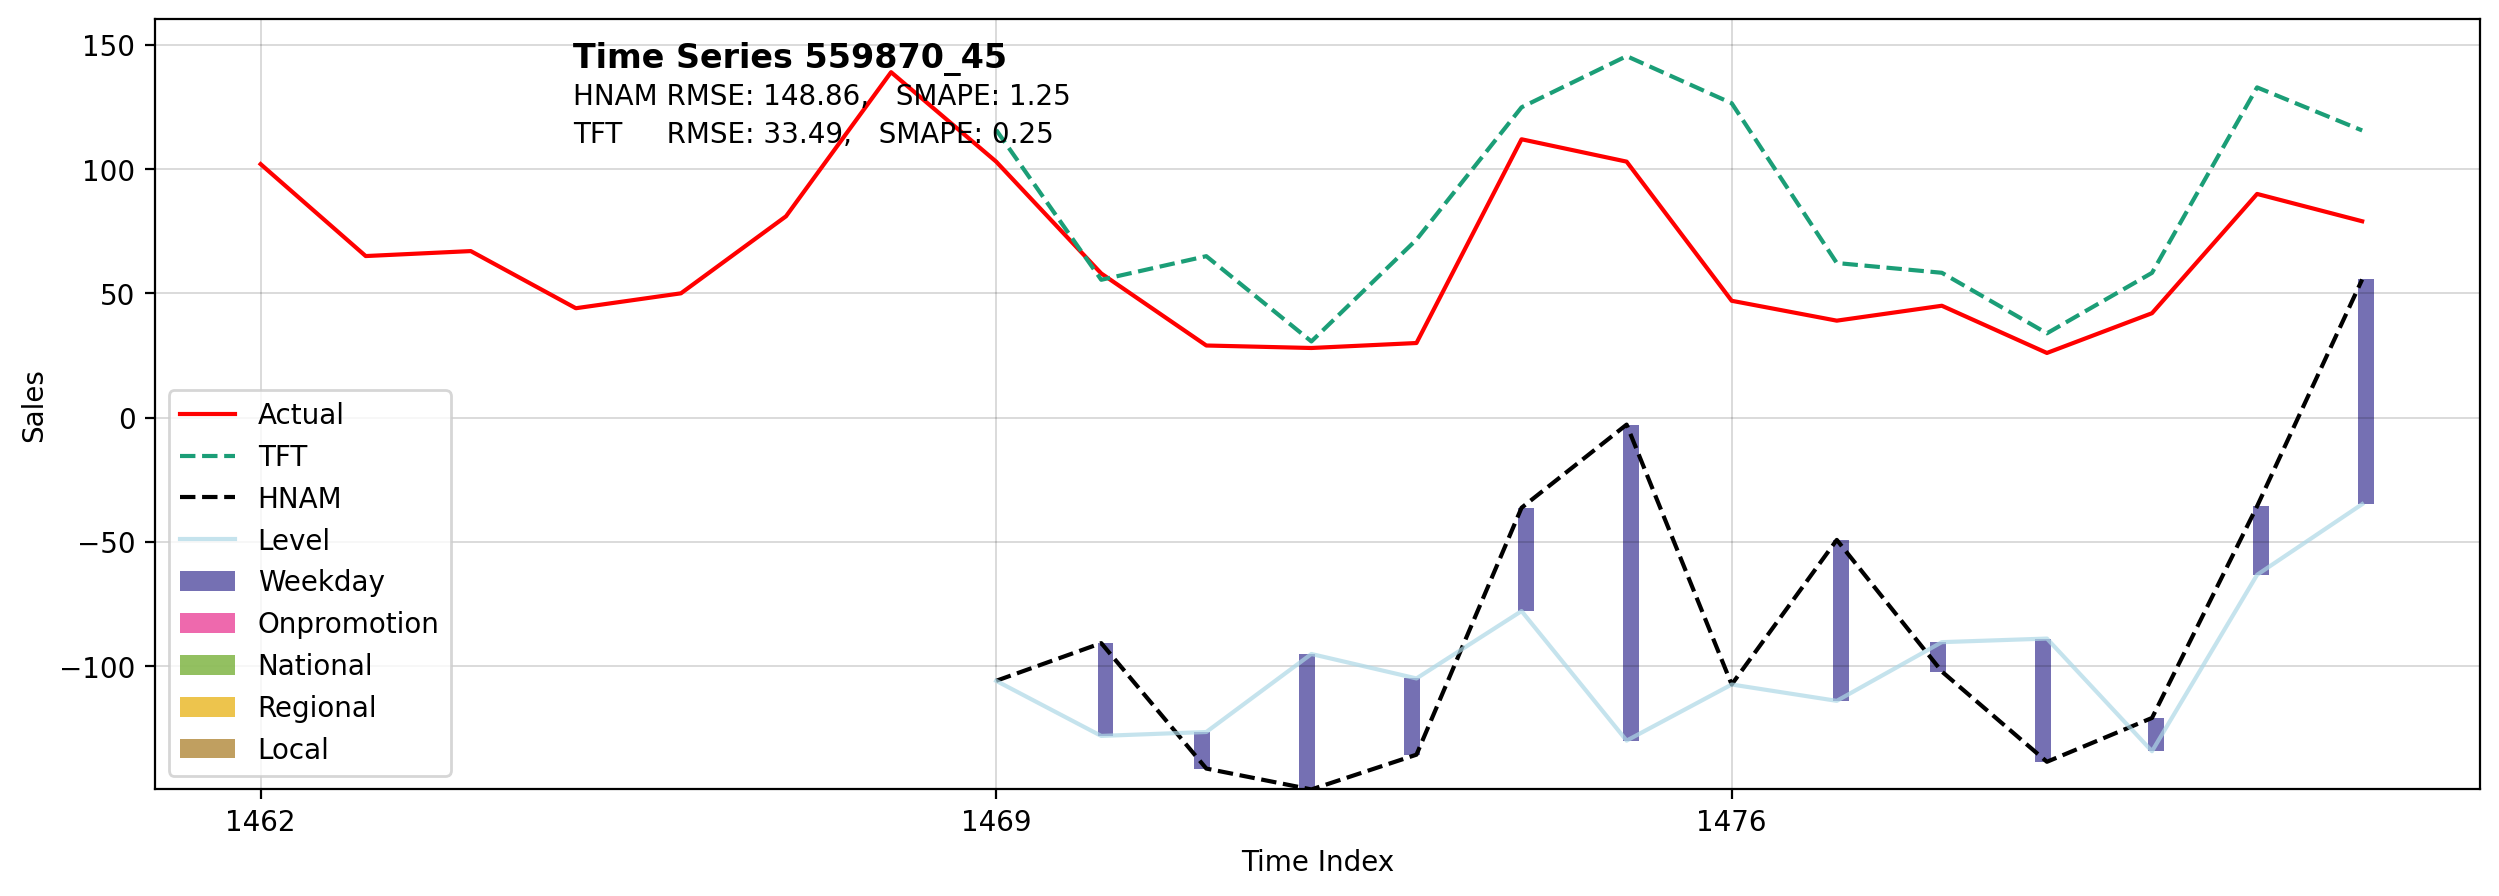

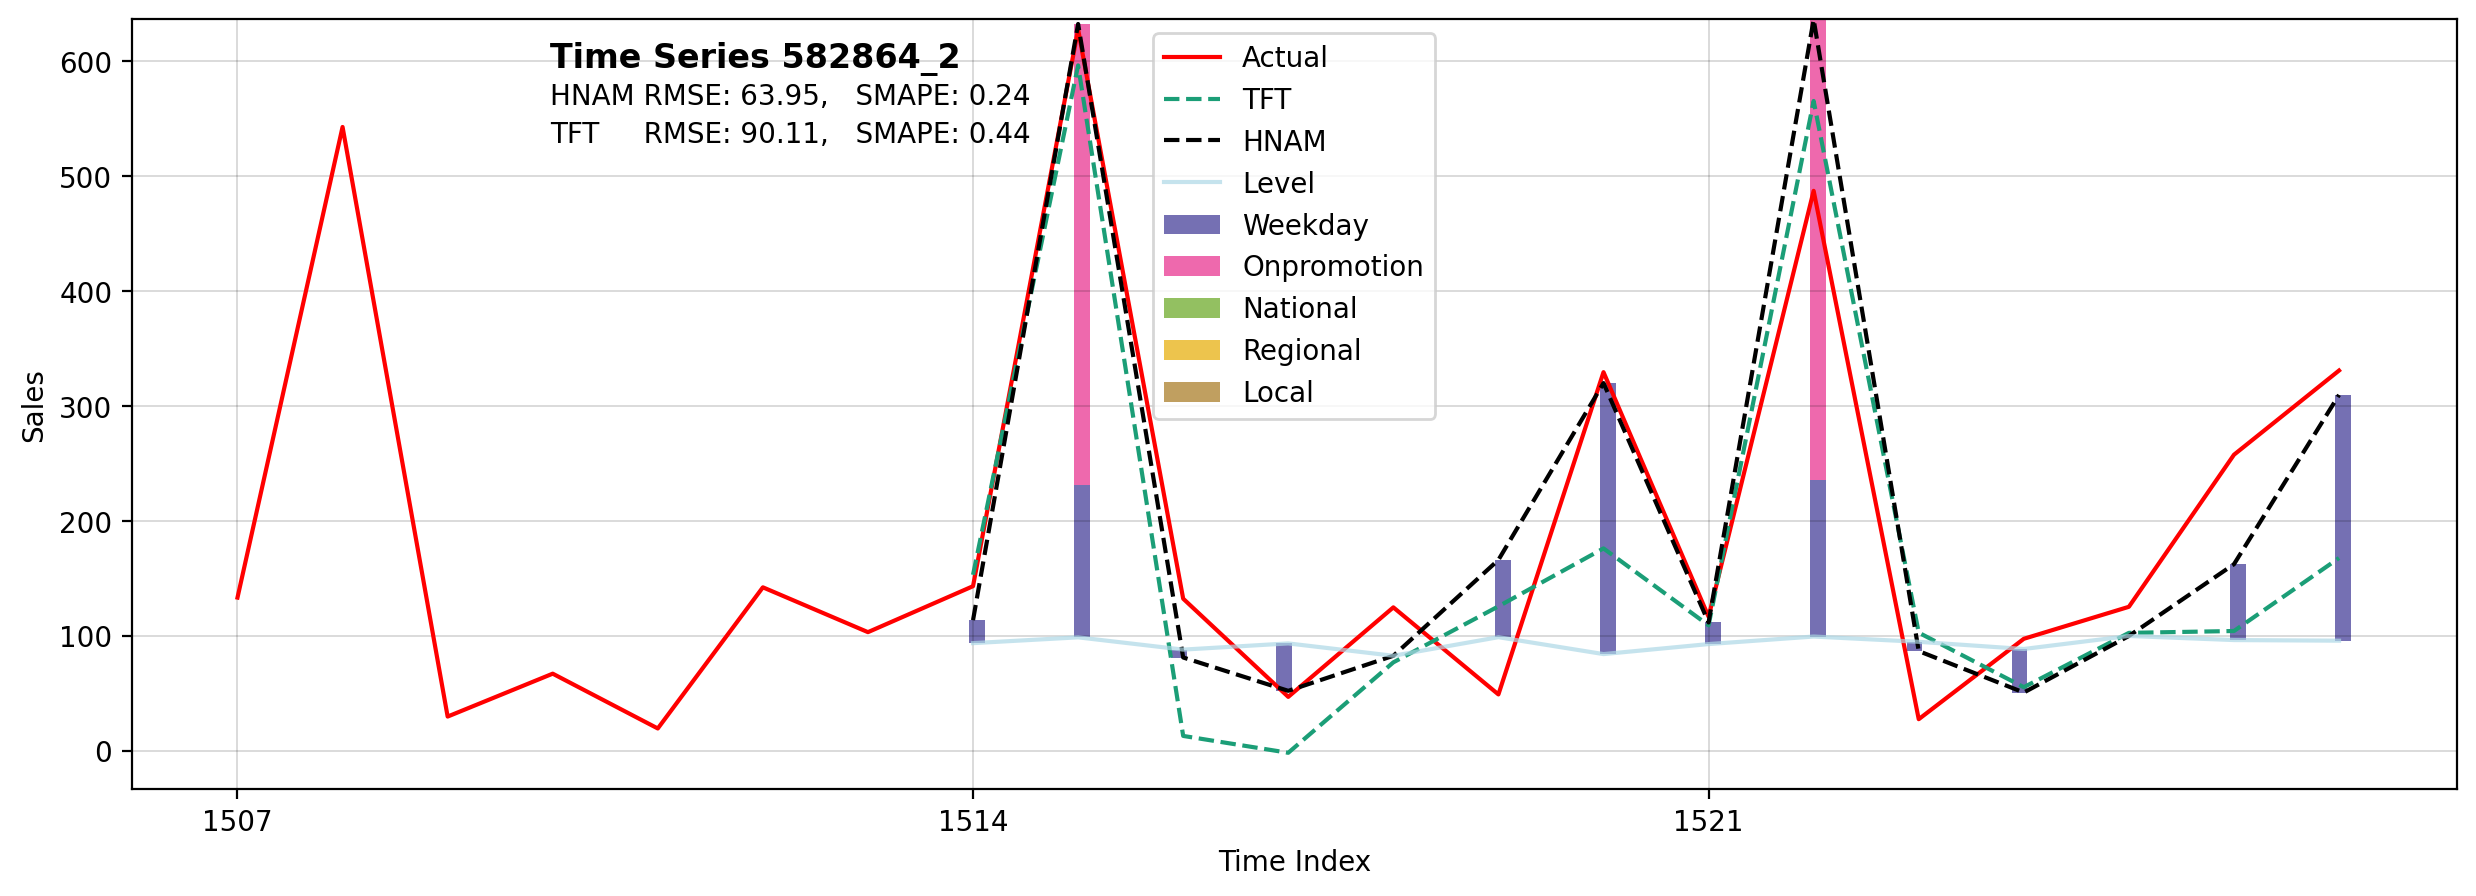

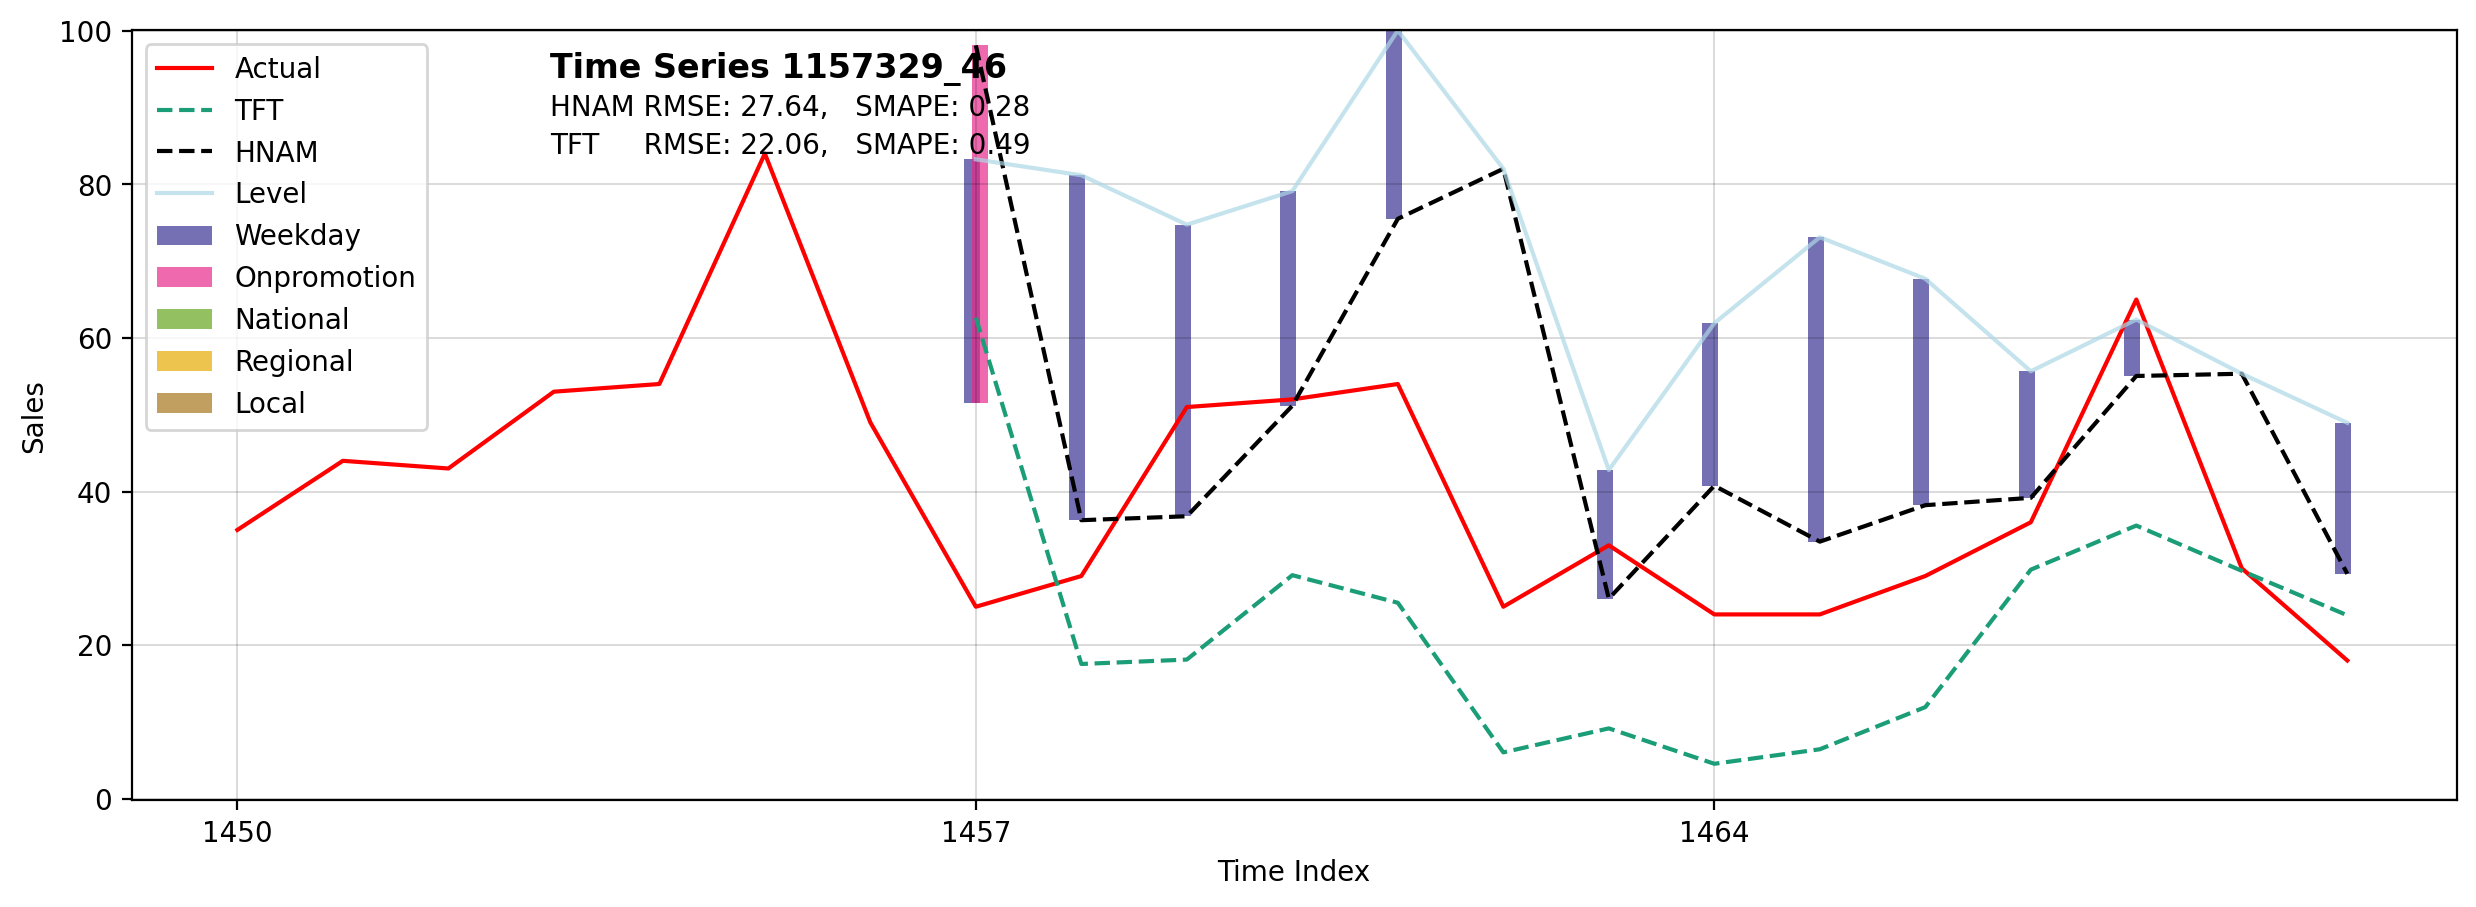

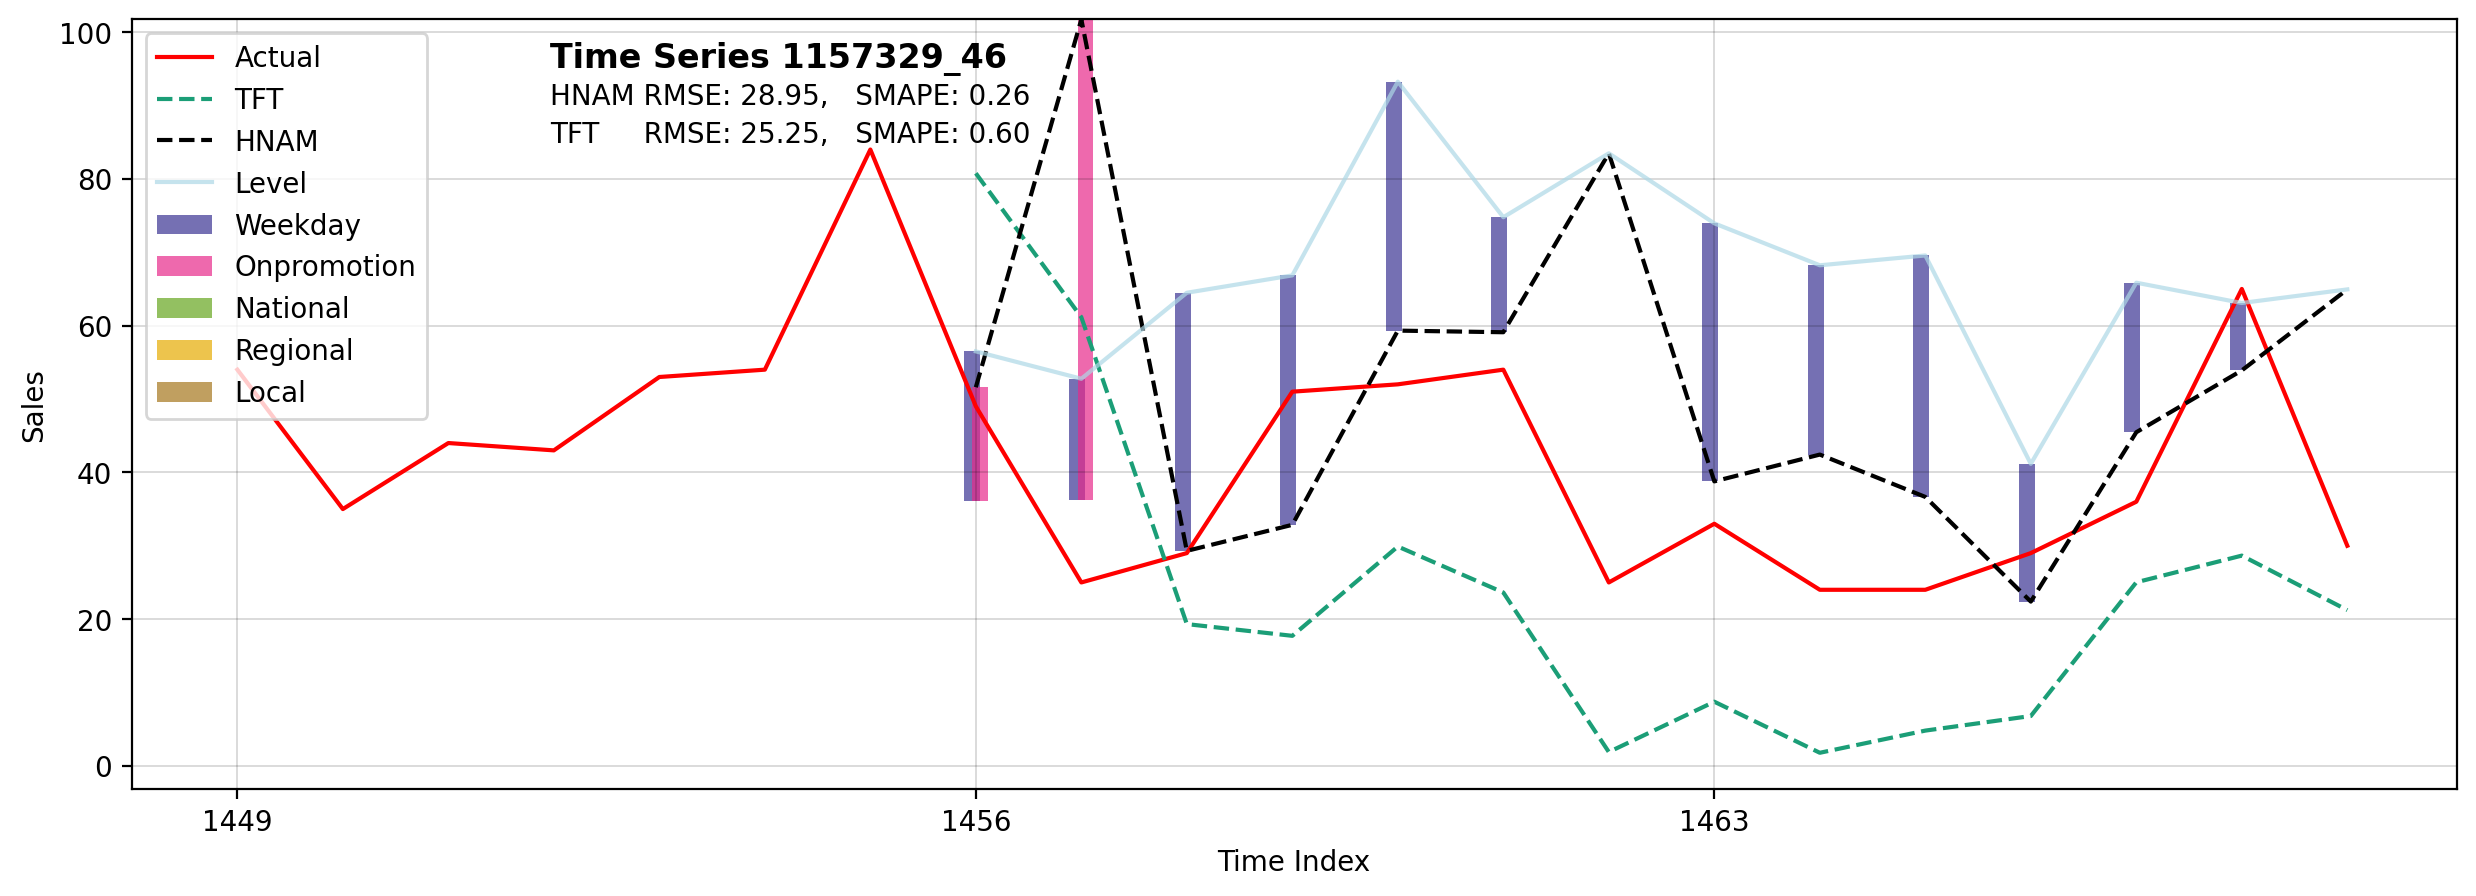

In [5]:
DATASET = 'Favorita'
data = pd.read_pickle(f'../Evaluation/{DATASET}/hnam.pkl')
ets_pred = pd.read_pickle(f'../Evaluation/{DATASET}/ets.pkl').rename(columns={'pred': 'ets'})
arima_pred = pd.read_pickle(f'../Evaluation/{DATASET}/sarimax.pkl').rename(columns={'pred': 'arima'})
tft_pred = pd.read_pickle(f'../Evaluation/{DATASET}/tft.pkl').rename(columns={'pred': 'tft'})

data = data.merge(ets_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
data = data.merge(arima_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
data = data.merge(tft_pred,on=['time_series', 'time_idx', 'pred_idx', 'h'],how='left')
actuals = pd.read_pickle(f'../Processed/{DATASET}/{DATASET.lower()}_data.pkl').query('time_idx > @data.time_idx.min() - 200')
actuals['time_idx'] = actuals['time_idx'].astype(int)
data['time_idx'] = data['time_idx'].astype(int)
data['pred_idx'] = data['pred_idx'].astype(int)
tss = list(data['time_series'].unique())
tidxs = list(data['time_idx'].unique())
huge_diff = pd.read_pickle(f'tft_hnam_diff_{DATASET.lower()}.pkl')
for i in list(range(5)) + list(range(-6,-1)):
    ts      = huge_diff.index[i][0]
    tidx    = huge_diff.index[i][1]
    plot_fc(ts,tidx,history=7,f=7)